
![alt text](https://pbs.twimg.com/media/DilKBjUVsAA74j1.jpg)

## Background Data

- Where there is salt, there is oil.
- But where is the salt?
- Classifying seismic imaging currently requires human (salt/not salt)
- Can we use an algorithm to do this instead? (yes)
- Seismic data is like an ultra-sound of the subsurface
- It uses wavelengths around 1m to 100m
- The Society of Exploration Geophysicists has 10K publications using the keyword 'salt'
- We can think of Earth as layered.
- Sand gets deposited on top of existing sand. And in comes the salt.
- There is an entire research branch dedicated to salt tectonics, that is the movement of salt in the subsurface.

## Our steps

- Install Dependencies
- Upload our Dataset
- View the labeled seismic imaging data
- Plot the depth distribution in the training data 
- Plot the proportion of salt vs depth in the training data
- Build a U-Net algorithm to learn the mapping between seismic images and the salt filter mask


In [1]:
#read/write image data
#!pip install imageio
#deep learning library
#!pip install torch
#access kaggle datasets from colab
#!pip install kaggle
#model loading
#!pip install ipywidgets

In [2]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

#needed so that GPU memory is properly allocated
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


In [3]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [4]:
location = 'work'

if(location == 'home'):
    PATH = '/home/katou/Python/Data/Kaggle Salt Id/'
elif(location == 'work'):
    PATH = "C:\\Users\\SCatheline\\Documents\\GitHub repo\\Salt Dataset\\"
else:
    print('Unavailable location.')
#train image + mask data
train_mask = pd.read_csv(PATH+'train.csv')
#depth data
depth = pd.read_csv(PATH+'depths.csv')
#training path
train_path = PATH+'train'

#list of files
file_list = list(train_mask['id'].values)
#define our dataset using our class
dataset = TGSSaltDataset(train_path, file_list)

In [5]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

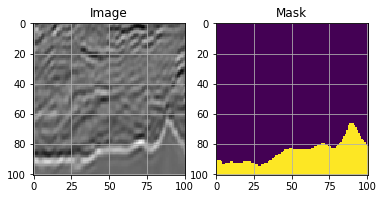

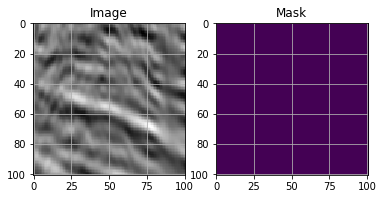

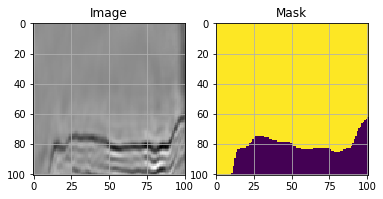

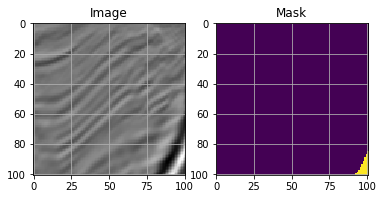

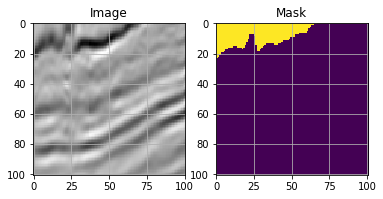

In [6]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

![alt text](https://sites.google.com/a/ruknuddin.com/inqilab-patel-magazine/_/rsrc/1525765922681/term-of-the-day/runlengthencoding/RunLengthEncoding.PNG)



In [7]:
#convert to image
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [8]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [9]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [10]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


In [11]:
from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, Activation,Add, Multiply
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf


Using TensorFlow backend.


In [12]:
im_width = 128
im_height = 128
border = 5
im_chan = 3 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [13]:
#define exponential and log layer to modify the input image
from keras import backend as K
from keras.engine.topology import Layer

In [14]:
from model import Deeplabv3
model = Deeplabv3(input_shape=(im_width,im_height,3), classes=1, OS=8, drop = 0.5)  

#model = Model(inputs=[input_img, input_features], outputs=[outputs])

opt_adam = Adam(lr=1e-3)
model.compile(optimizer=opt_adam, loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()
print(model.non_trainable_weights)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 64, 64, 32)   128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 64, 64, 32)   0           Conv_BN[0][0]                    
__________________________________________________________________________________________________
expanded_c

In [15]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"/images"))[2] if location == 'home' else next(os.walk(train_path+"\\images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True) if location == 'home' else load_img(path + '\\images\\' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True)) if location == 'home' else img_to_array(load_img(path + '\\masks\\' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    X[n, ..., 2] = x_img.squeeze() / 255 
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:21<00:00, 189.55it/s]


Done!


In [16]:
print(y.shape)
print(np.mean(y[10,:,:,0]))


(4000, 128, 128, 1)
0.62924933


(array([1984.,  327.,  229.,  215.,  199.,  214.,  196.,  163.,  157.,
         316.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

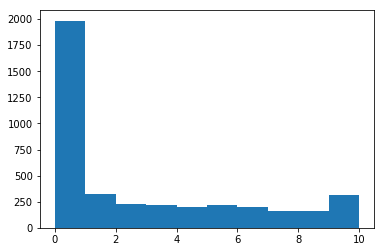

In [17]:
#split the data using the coverage of salt in the image
Cov = np.zeros((y.shape[0],),dtype = float)
for i in range(y.shape[0]):
    Cov[i] = int(round(10*np.mean(y[i,:,:,0])))


plt.hist(Cov,bins=10)


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, 
                                                                    test_size=0.15, stratify=Cov, random_state=42)


print(X_train.shape)
print(X_valid.shape)
print(X_feat_train.shape) 
print(X_feat_valid.shape )
print(y_train.shape )
print(y_valid.shape)

(3400, 128, 128, 3)
(600, 128, 128, 3)
(3400, 1)
(600, 1)
(3400, 128, 128, 1)
(600, 128, 128, 1)


Data Augmentation on the input
1) Images can be flipped vertically
2) Image can be tilted
3) Image can be dilated

!!!! NOTE that the augmentation can be added to the classification problem by predicting the class on augmented validation data. Here it should not be used because any transformation on the validation data will just mess up the pixel-wise classification 

In [19]:
from keras.preprocessing.image import ImageDataGenerator

X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
X_feat_train = np.append(X_feat_train,[x for x in X_feat_train],axis=0)


#rot = skimage.transform.rotate(img, angle=45, mode='reflect')
#scale_out = skimage.transform.rescale(img, scale=2.0, mode='constant')

#random crop of the image

# Adding Gaussian noise
#noise = tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=1.0,
#dtype=tf.float32)
#output = tf.add(x, noise)

#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,rescale=1./255,rotation_range=40,width_shift_range=0.2,
#    height_shift_range=0.2,fill_mode='nearest'
#   )

# = train_datagen.flow_from_directory(train_data_dir,
#    target_size=(sz, sz),
#    batch_size=batch_size, class_mode='binary')
print(X_train.shape)
print(X_valid.shape)
print(X_feat_train.shape) 
print(X_feat_valid.shape )
print(y_train.shape )
print(y_valid.shape)


(6800, 128, 128, 3)
(600, 128, 128, 3)
(6800, 1)
(600, 1)
(6800, 128, 128, 1)
(600, 128, 128, 1)


(array([8.3470644e+07, 8.6488000e+04, 7.5468000e+04, 7.6860000e+04,
        7.5072000e+04, 7.2286000e+04, 7.6766000e+04, 7.6042000e+04,
        9.3397400e+05, 2.6467600e+07]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

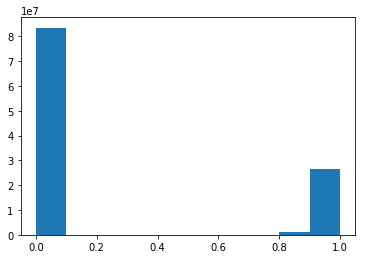

In [38]:
#print(np.min(X_train[:,:,:,-4]))
#print(np.max(X_train[:,:,:,-4]))
plt.hist(y_train.reshape(-1))

In [21]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1,min_lr=0.00001,factor=0.5),
    ModelCheckpoint(PATH+'model_DL3_lr=1e-3.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit( X_train, y_train, batch_size=16, epochs=100, verbose =1,callbacks=callbacks,
                    validation_data=(X_valid, y_valid)
                   )

Train on 6800 samples, validate on 600 samples
Epoch 1/100


4976/6800 [====================>.........] - ETA: 1:22:32 - loss: 3.53 - ETA: 44:00 - loss: 2.9869 - ETA: 31:09 - loss: 2.59 - ETA: 24:43 - loss: 3.05 - ETA: 20:51 - loss: 3.53 - ETA: 18:16 - loss: 3.72 - ETA: 16:25 - loss: 3.71 - ETA: 15:02 - loss: 3.44 - ETA: 13:57 - loss: 3.33 - ETA: 13:05 - loss: 3.31 - ETA: 12:22 - loss: 3.33 - ETA: 11:46 - loss: 3.32 - ETA: 11:16 - loss: 3.27 - ETA: 10:50 - loss: 3.25 - ETA: 10:27 - loss: 3.26 - ETA: 10:07 - loss: 3.34 - ETA: 9:49 - loss: 3.3396 - ETA: 9:33 - loss: 3.358 - ETA: 9:19 - loss: 3.308 - ETA: 9:06 - loss: 3.335 - ETA: 8:54 - loss: 3.271 - ETA: 8:43 - loss: 3.334 - ETA: 8:33 - loss: 3.344 - ETA: 8:24 - loss: 3.364 - ETA: 8:16 - loss: 3.376 - ETA: 8:08 - loss: 3.317 - ETA: 8:00 - loss: 3.327 - ETA: 7:53 - loss: 3.378 - ETA: 7:47 - loss: 3.410 - ETA: 7:41 - loss: 3.393 - ETA: 7:35 - loss: 3.425 - ETA: 7:29 - loss: 3.426 - ETA: 7:24 - loss: 3.433 - ETA: 7:19 - loss: 3.488 - ETA: 7:14 - loss: 3.526 - ETA: 7:10 - loss: 3.522 - ETA: 7:06 - lo

6800/6800 [==============================] - ETA: 1:35 - loss: 3.969 - ETA: 1:34 - loss: 3.965 - ETA: 1:33 - loss: 3.966 - ETA: 1:32 - loss: 3.965 - ETA: 1:31 - loss: 3.962 - ETA: 1:30 - loss: 3.958 - ETA: 1:29 - loss: 3.964 - ETA: 1:29 - loss: 3.970 - ETA: 1:28 - loss: 3.969 - ETA: 1:27 - loss: 3.968 - ETA: 1:26 - loss: 3.963 - ETA: 1:25 - loss: 3.959 - ETA: 1:24 - loss: 3.959 - ETA: 1:23 - loss: 3.955 - ETA: 1:23 - loss: 3.955 - ETA: 1:22 - loss: 3.961 - ETA: 1:21 - loss: 3.961 - ETA: 1:20 - loss: 3.964 - ETA: 1:19 - loss: 3.960 - ETA: 1:18 - loss: 3.964 - ETA: 1:18 - loss: 3.969 - ETA: 1:17 - loss: 3.969 - ETA: 1:16 - loss: 3.974 - ETA: 1:15 - loss: 3.973 - ETA: 1:14 - loss: 3.971 - ETA: 1:13 - loss: 3.971 - ETA: 1:12 - loss: 3.976 - ETA: 1:12 - loss: 3.981 - ETA: 1:11 - loss: 3.983 - ETA: 1:10 - loss: 3.980 - ETA: 1:09 - loss: 3.985 - ETA: 1:08 - loss: 3.986 - ETA: 1:07 - loss: 3.983 - ETA: 1:07 - loss: 3.987 - ETA: 1:06 - loss: 3.992 - ETA: 1:05 - loss: 3.992 - ETA: 1:04 - loss: 3

5024/6800 [=====================>........] - ETA: 5:39 - loss: 3.352 - ETA: 5:38 - loss: 3.909 - ETA: 5:38 - loss: 4.283 - ETA: 5:37 - loss: 3.966 - ETA: 5:37 - loss: 3.875 - ETA: 5:36 - loss: 3.848 - ETA: 5:35 - loss: 3.850 - ETA: 5:34 - loss: 3.831 - ETA: 5:33 - loss: 4.098 - ETA: 5:33 - loss: 4.178 - ETA: 5:32 - loss: 4.264 - ETA: 5:31 - loss: 4.187 - ETA: 5:30 - loss: 4.249 - ETA: 5:29 - loss: 4.372 - ETA: 5:28 - loss: 4.288 - ETA: 5:28 - loss: 4.234 - ETA: 5:27 - loss: 4.161 - ETA: 5:26 - loss: 4.104 - ETA: 5:25 - loss: 4.251 - ETA: 5:25 - loss: 4.271 - ETA: 5:24 - loss: 4.237 - ETA: 5:23 - loss: 4.072 - ETA: 5:22 - loss: 4.001 - ETA: 5:21 - loss: 3.923 - ETA: 5:21 - loss: 3.908 - ETA: 5:20 - loss: 3.927 - ETA: 5:19 - loss: 4.072 - ETA: 5:18 - loss: 4.005 - ETA: 5:17 - loss: 3.974 - ETA: 5:17 - loss: 4.017 - ETA: 5:16 - loss: 4.005 - ETA: 5:15 - loss: 3.994 - ETA: 5:14 - loss: 3.957 - ETA: 5:13 - loss: 3.965 - ETA: 5:13 - loss: 3.936 - ETA: 5:12 - loss: 3.931 - ETA: 5:11 - loss: 3

6800/6800 [==============================] - ETA: 1:28 - loss: 4.003 - ETA: 1:27 - loss: 3.998 - ETA: 1:26 - loss: 3.999 - ETA: 1:25 - loss: 3.999 - ETA: 1:25 - loss: 3.992 - ETA: 1:24 - loss: 3.992 - ETA: 1:23 - loss: 3.993 - ETA: 1:22 - loss: 3.984 - ETA: 1:21 - loss: 3.988 - ETA: 1:21 - loss: 3.989 - ETA: 1:20 - loss: 3.990 - ETA: 1:19 - loss: 3.988 - ETA: 1:18 - loss: 3.986 - ETA: 1:17 - loss: 3.985 - ETA: 1:17 - loss: 3.980 - ETA: 1:16 - loss: 3.981 - ETA: 1:15 - loss: 3.984 - ETA: 1:14 - loss: 3.982 - ETA: 1:13 - loss: 3.979 - ETA: 1:13 - loss: 3.990 - ETA: 1:12 - loss: 3.990 - ETA: 1:11 - loss: 3.999 - ETA: 1:10 - loss: 4.004 - ETA: 1:09 - loss: 4.000 - ETA: 1:09 - loss: 3.998 - ETA: 1:08 - loss: 3.994 - ETA: 1:07 - loss: 3.989 - ETA: 1:06 - loss: 3.992 - ETA: 1:05 - loss: 3.995 - ETA: 1:05 - loss: 3.998 - ETA: 1:04 - loss: 3.998 - ETA: 1:03 - loss: 4.002 - ETA: 1:02 - loss: 3.999 - ETA: 1:01 - loss: 3.996 - ETA: 1:00 - loss: 3.998 - ETA: 1:00 - loss: 3.994 - ETA: 59s - loss: 3.

5024/6800 [=====================>........] - ETA: 5:40 - loss: 3.564 - ETA: 5:39 - loss: 3.728 - ETA: 5:38 - loss: 3.913 - ETA: 5:37 - loss: 4.520 - ETA: 5:36 - loss: 4.870 - ETA: 5:36 - loss: 4.650 - ETA: 5:35 - loss: 4.185 - ETA: 5:34 - loss: 4.320 - ETA: 5:33 - loss: 4.292 - ETA: 5:32 - loss: 4.206 - ETA: 5:32 - loss: 4.194 - ETA: 5:31 - loss: 4.234 - ETA: 5:30 - loss: 4.258 - ETA: 5:29 - loss: 4.130 - ETA: 5:28 - loss: 4.140 - ETA: 5:28 - loss: 4.051 - ETA: 5:27 - loss: 4.036 - ETA: 5:26 - loss: 4.034 - ETA: 5:25 - loss: 4.039 - ETA: 5:24 - loss: 3.996 - ETA: 5:24 - loss: 3.972 - ETA: 5:23 - loss: 3.997 - ETA: 5:22 - loss: 4.036 - ETA: 5:21 - loss: 4.157 - ETA: 5:20 - loss: 4.178 - ETA: 5:20 - loss: 4.167 - ETA: 5:19 - loss: 4.124 - ETA: 5:18 - loss: 4.188 - ETA: 5:17 - loss: 4.190 - ETA: 5:16 - loss: 4.209 - ETA: 5:16 - loss: 4.227 - ETA: 5:15 - loss: 4.280 - ETA: 5:14 - loss: 4.305 - ETA: 5:13 - loss: 4.222 - ETA: 5:12 - loss: 4.224 - ETA: 5:12 - loss: 4.197 - ETA: 5:11 - loss: 4

6800/6800 [==============================] - ETA: 1:28 - loss: 3.980 - ETA: 1:27 - loss: 3.985 - ETA: 1:26 - loss: 3.980 - ETA: 1:25 - loss: 3.987 - ETA: 1:25 - loss: 3.991 - ETA: 1:24 - loss: 3.992 - ETA: 1:23 - loss: 3.992 - ETA: 1:22 - loss: 4.000 - ETA: 1:21 - loss: 4.003 - ETA: 1:21 - loss: 4.005 - ETA: 1:20 - loss: 4.003 - ETA: 1:19 - loss: 4.007 - ETA: 1:18 - loss: 4.004 - ETA: 1:17 - loss: 4.000 - ETA: 1:17 - loss: 3.995 - ETA: 1:16 - loss: 3.998 - ETA: 1:15 - loss: 4.000 - ETA: 1:14 - loss: 4.003 - ETA: 1:13 - loss: 4.008 - ETA: 1:13 - loss: 4.009 - ETA: 1:12 - loss: 4.002 - ETA: 1:11 - loss: 3.999 - ETA: 1:10 - loss: 3.998 - ETA: 1:09 - loss: 3.997 - ETA: 1:09 - loss: 3.997 - ETA: 1:08 - loss: 4.000 - ETA: 1:07 - loss: 4.003 - ETA: 1:06 - loss: 3.998 - ETA: 1:05 - loss: 3.995 - ETA: 1:05 - loss: 3.993 - ETA: 1:04 - loss: 3.991 - ETA: 1:03 - loss: 3.989 - ETA: 1:02 - loss: 3.986 - ETA: 1:01 - loss: 3.986 - ETA: 1:00 - loss: 3.989 - ETA: 1:00 - loss: 3.993 - ETA: 59s - loss: 3.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 2.597 - ETA: 5:38 - loss: 2.732 - ETA: 5:37 - loss: 3.977 - ETA: 5:36 - loss: 3.627 - ETA: 5:35 - loss: 3.399 - ETA: 5:35 - loss: 3.411 - ETA: 5:34 - loss: 3.355 - ETA: 5:33 - loss: 3.423 - ETA: 5:32 - loss: 3.470 - ETA: 5:32 - loss: 3.471 - ETA: 5:31 - loss: 3.612 - ETA: 5:30 - loss: 3.609 - ETA: 5:29 - loss: 3.656 - ETA: 5:29 - loss: 3.547 - ETA: 5:28 - loss: 3.557 - ETA: 5:27 - loss: 3.624 - ETA: 5:26 - loss: 3.696 - ETA: 5:25 - loss: 3.734 - ETA: 5:24 - loss: 3.776 - ETA: 5:24 - loss: 3.762 - ETA: 5:23 - loss: 3.678 - ETA: 5:22 - loss: 3.643 - ETA: 5:22 - loss: 3.705 - ETA: 5:21 - loss: 3.696 - ETA: 5:20 - loss: 3.736 - ETA: 5:19 - loss: 3.744 - ETA: 5:18 - loss: 3.753 - ETA: 5:18 - loss: 3.785 - ETA: 5:17 - loss: 3.873 - ETA: 5:16 - loss: 3.851 - ETA: 5:15 - loss: 3.924 - ETA: 5:14 - loss: 3.911 - ETA: 5:14 - loss: 3.882 - ETA: 5:13 - loss: 3.914 - ETA: 5:12 - loss: 3.855 - ETA: 5:11 - loss: 3.853 - ETA: 5:10 - loss: 3

6800/6800 [==============================] - ETA: 1:28 - loss: 3.941 - ETA: 1:27 - loss: 3.942 - ETA: 1:26 - loss: 3.945 - ETA: 1:25 - loss: 3.947 - ETA: 1:24 - loss: 3.941 - ETA: 1:24 - loss: 3.945 - ETA: 1:23 - loss: 3.939 - ETA: 1:22 - loss: 3.948 - ETA: 1:21 - loss: 3.944 - ETA: 1:20 - loss: 3.939 - ETA: 1:20 - loss: 3.939 - ETA: 1:19 - loss: 3.938 - ETA: 1:18 - loss: 3.943 - ETA: 1:17 - loss: 3.945 - ETA: 1:16 - loss: 3.949 - ETA: 1:16 - loss: 3.952 - ETA: 1:15 - loss: 3.951 - ETA: 1:14 - loss: 3.945 - ETA: 1:13 - loss: 3.943 - ETA: 1:12 - loss: 3.952 - ETA: 1:12 - loss: 3.948 - ETA: 1:11 - loss: 3.943 - ETA: 1:10 - loss: 3.944 - ETA: 1:09 - loss: 3.951 - ETA: 1:08 - loss: 3.948 - ETA: 1:08 - loss: 3.947 - ETA: 1:07 - loss: 3.940 - ETA: 1:06 - loss: 3.941 - ETA: 1:05 - loss: 3.944 - ETA: 1:04 - loss: 3.946 - ETA: 1:04 - loss: 3.946 - ETA: 1:03 - loss: 3.949 - ETA: 1:02 - loss: 3.946 - ETA: 1:01 - loss: 3.947 - ETA: 1:00 - loss: 3.950 - ETA: 1:00 - loss: 3.949 - ETA: 59s - loss: 3.

5024/6800 [=====================>........] - ETA: 5:38 - loss: 2.155 - ETA: 5:37 - loss: 3.691 - ETA: 5:37 - loss: 4.294 - ETA: 5:37 - loss: 4.140 - ETA: 5:36 - loss: 3.874 - ETA: 5:36 - loss: 3.929 - ETA: 5:35 - loss: 3.868 - ETA: 5:34 - loss: 3.823 - ETA: 5:33 - loss: 4.087 - ETA: 5:33 - loss: 4.240 - ETA: 5:32 - loss: 4.157 - ETA: 5:31 - loss: 3.997 - ETA: 5:30 - loss: 3.953 - ETA: 5:29 - loss: 4.094 - ETA: 5:28 - loss: 4.059 - ETA: 5:27 - loss: 4.109 - ETA: 5:27 - loss: 4.103 - ETA: 5:26 - loss: 3.957 - ETA: 5:25 - loss: 3.950 - ETA: 5:24 - loss: 3.986 - ETA: 5:23 - loss: 3.966 - ETA: 5:22 - loss: 4.002 - ETA: 5:22 - loss: 4.024 - ETA: 5:21 - loss: 4.091 - ETA: 5:20 - loss: 4.164 - ETA: 5:19 - loss: 4.211 - ETA: 5:18 - loss: 4.193 - ETA: 5:18 - loss: 4.148 - ETA: 5:17 - loss: 4.169 - ETA: 5:16 - loss: 4.130 - ETA: 5:15 - loss: 4.103 - ETA: 5:15 - loss: 4.083 - ETA: 5:14 - loss: 4.050 - ETA: 5:13 - loss: 4.042 - ETA: 5:12 - loss: 4.014 - ETA: 5:11 - loss: 3.960 - ETA: 5:11 - loss: 3

6800/6800 [==============================] - ETA: 1:28 - loss: 3.982 - ETA: 1:27 - loss: 3.984 - ETA: 1:26 - loss: 3.986 - ETA: 1:25 - loss: 3.987 - ETA: 1:25 - loss: 3.985 - ETA: 1:24 - loss: 3.983 - ETA: 1:23 - loss: 3.985 - ETA: 1:22 - loss: 3.981 - ETA: 1:21 - loss: 3.978 - ETA: 1:21 - loss: 3.981 - ETA: 1:20 - loss: 3.977 - ETA: 1:19 - loss: 3.979 - ETA: 1:18 - loss: 3.978 - ETA: 1:17 - loss: 3.975 - ETA: 1:17 - loss: 3.970 - ETA: 1:16 - loss: 3.972 - ETA: 1:15 - loss: 3.970 - ETA: 1:14 - loss: 3.973 - ETA: 1:13 - loss: 3.977 - ETA: 1:13 - loss: 3.976 - ETA: 1:12 - loss: 3.978 - ETA: 1:11 - loss: 3.978 - ETA: 1:10 - loss: 3.978 - ETA: 1:09 - loss: 3.971 - ETA: 1:09 - loss: 3.971 - ETA: 1:08 - loss: 3.965 - ETA: 1:07 - loss: 3.964 - ETA: 1:06 - loss: 3.968 - ETA: 1:05 - loss: 3.971 - ETA: 1:04 - loss: 3.968 - ETA: 1:04 - loss: 3.967 - ETA: 1:03 - loss: 3.969 - ETA: 1:02 - loss: 3.966 - ETA: 1:01 - loss: 3.964 - ETA: 1:00 - loss: 3.965 - ETA: 1:00 - loss: 3.965 - ETA: 59s - loss: 3.

5024/6800 [=====================>........] - ETA: 5:38 - loss: 5.540 - ETA: 5:38 - loss: 3.703 - ETA: 5:38 - loss: 3.578 - ETA: 5:37 - loss: 3.790 - ETA: 5:37 - loss: 3.954 - ETA: 5:36 - loss: 4.102 - ETA: 5:35 - loss: 4.417 - ETA: 5:34 - loss: 4.213 - ETA: 5:33 - loss: 4.392 - ETA: 5:33 - loss: 4.514 - ETA: 5:32 - loss: 4.357 - ETA: 5:31 - loss: 4.423 - ETA: 5:30 - loss: 4.376 - ETA: 5:29 - loss: 4.293 - ETA: 5:29 - loss: 4.222 - ETA: 5:28 - loss: 4.118 - ETA: 5:27 - loss: 4.084 - ETA: 5:26 - loss: 4.094 - ETA: 5:25 - loss: 4.150 - ETA: 5:25 - loss: 4.076 - ETA: 5:24 - loss: 4.052 - ETA: 5:23 - loss: 4.067 - ETA: 5:22 - loss: 3.953 - ETA: 5:21 - loss: 3.903 - ETA: 5:21 - loss: 3.868 - ETA: 5:20 - loss: 3.893 - ETA: 5:19 - loss: 3.928 - ETA: 5:18 - loss: 3.970 - ETA: 5:17 - loss: 3.974 - ETA: 5:16 - loss: 4.004 - ETA: 5:16 - loss: 3.958 - ETA: 5:15 - loss: 3.969 - ETA: 5:14 - loss: 3.940 - ETA: 5:13 - loss: 3.947 - ETA: 5:12 - loss: 3.907 - ETA: 5:12 - loss: 3.852 - ETA: 5:11 - loss: 3

6800/6800 [==============================] - ETA: 1:28 - loss: 3.966 - ETA: 1:27 - loss: 3.960 - ETA: 1:26 - loss: 3.956 - ETA: 1:25 - loss: 3.952 - ETA: 1:25 - loss: 3.945 - ETA: 1:24 - loss: 3.942 - ETA: 1:23 - loss: 3.944 - ETA: 1:22 - loss: 3.937 - ETA: 1:21 - loss: 3.935 - ETA: 1:21 - loss: 3.932 - ETA: 1:20 - loss: 3.933 - ETA: 1:19 - loss: 3.940 - ETA: 1:18 - loss: 3.937 - ETA: 1:17 - loss: 3.939 - ETA: 1:17 - loss: 3.933 - ETA: 1:16 - loss: 3.935 - ETA: 1:15 - loss: 3.937 - ETA: 1:14 - loss: 3.938 - ETA: 1:13 - loss: 3.936 - ETA: 1:13 - loss: 3.944 - ETA: 1:12 - loss: 3.941 - ETA: 1:11 - loss: 3.942 - ETA: 1:10 - loss: 3.943 - ETA: 1:09 - loss: 3.946 - ETA: 1:09 - loss: 3.944 - ETA: 1:08 - loss: 3.946 - ETA: 1:07 - loss: 3.942 - ETA: 1:06 - loss: 3.940 - ETA: 1:05 - loss: 3.939 - ETA: 1:05 - loss: 3.938 - ETA: 1:04 - loss: 3.941 - ETA: 1:03 - loss: 3.942 - ETA: 1:02 - loss: 3.937 - ETA: 1:01 - loss: 3.932 - ETA: 1:01 - loss: 3.933 - ETA: 1:00 - loss: 3.932 - ETA: 59s - loss: 3.

5024/6800 [=====================>........] - ETA: 5:42 - loss: 2.577 - ETA: 5:42 - loss: 3.815 - ETA: 5:42 - loss: 3.723 - ETA: 5:42 - loss: 3.577 - ETA: 5:42 - loss: 3.447 - ETA: 5:41 - loss: 3.623 - ETA: 5:40 - loss: 3.340 - ETA: 5:38 - loss: 3.451 - ETA: 5:37 - loss: 3.322 - ETA: 5:36 - loss: 3.448 - ETA: 5:35 - loss: 3.835 - ETA: 5:34 - loss: 3.807 - ETA: 5:33 - loss: 3.660 - ETA: 5:32 - loss: 3.582 - ETA: 5:31 - loss: 3.494 - ETA: 5:30 - loss: 3.536 - ETA: 5:29 - loss: 3.444 - ETA: 5:28 - loss: 3.422 - ETA: 5:27 - loss: 3.449 - ETA: 5:26 - loss: 3.356 - ETA: 5:25 - loss: 3.411 - ETA: 5:24 - loss: 3.403 - ETA: 5:23 - loss: 3.437 - ETA: 5:22 - loss: 3.425 - ETA: 5:22 - loss: 3.421 - ETA: 5:21 - loss: 3.418 - ETA: 5:20 - loss: 3.396 - ETA: 5:19 - loss: 3.414 - ETA: 5:18 - loss: 3.440 - ETA: 5:17 - loss: 3.416 - ETA: 5:17 - loss: 3.529 - ETA: 5:16 - loss: 3.541 - ETA: 5:15 - loss: 3.477 - ETA: 5:14 - loss: 3.437 - ETA: 5:13 - loss: 3.425 - ETA: 5:12 - loss: 3.395 - ETA: 5:12 - loss: 3

6800/6800 [==============================] - ETA: 1:28 - loss: 2.420 - ETA: 1:27 - loss: 2.418 - ETA: 1:26 - loss: 2.416 - ETA: 1:25 - loss: 2.413 - ETA: 1:25 - loss: 2.416 - ETA: 1:24 - loss: 2.413 - ETA: 1:23 - loss: 2.411 - ETA: 1:22 - loss: 2.411 - ETA: 1:21 - loss: 2.408 - ETA: 1:21 - loss: 2.407 - ETA: 1:20 - loss: 2.403 - ETA: 1:19 - loss: 2.397 - ETA: 1:18 - loss: 2.394 - ETA: 1:17 - loss: 2.390 - ETA: 1:17 - loss: 2.386 - ETA: 1:16 - loss: 2.386 - ETA: 1:15 - loss: 2.384 - ETA: 1:14 - loss: 2.383 - ETA: 1:13 - loss: 2.377 - ETA: 1:13 - loss: 2.375 - ETA: 1:12 - loss: 2.371 - ETA: 1:11 - loss: 2.365 - ETA: 1:10 - loss: 2.362 - ETA: 1:09 - loss: 2.357 - ETA: 1:09 - loss: 2.355 - ETA: 1:08 - loss: 2.358 - ETA: 1:07 - loss: 2.358 - ETA: 1:06 - loss: 2.362 - ETA: 1:05 - loss: 2.359 - ETA: 1:05 - loss: 2.356 - ETA: 1:04 - loss: 2.356 - ETA: 1:03 - loss: 2.351 - ETA: 1:02 - loss: 2.347 - ETA: 1:01 - loss: 2.344 - ETA: 1:01 - loss: 2.346 - ETA: 1:00 - loss: 2.342 - ETA: 59s - loss: 2.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.660 - ETA: 5:39 - loss: 0.851 - ETA: 5:38 - loss: 0.994 - ETA: 5:38 - loss: 1.013 - ETA: 5:37 - loss: 0.975 - ETA: 5:36 - loss: 0.929 - ETA: 5:36 - loss: 0.960 - ETA: 5:35 - loss: 0.983 - ETA: 5:34 - loss: 1.001 - ETA: 5:33 - loss: 0.974 - ETA: 5:32 - loss: 0.947 - ETA: 5:32 - loss: 0.996 - ETA: 5:31 - loss: 0.965 - ETA: 5:30 - loss: 0.948 - ETA: 5:29 - loss: 1.022 - ETA: 5:28 - loss: 1.040 - ETA: 5:27 - loss: 1.018 - ETA: 5:27 - loss: 1.026 - ETA: 5:26 - loss: 1.036 - ETA: 5:25 - loss: 1.046 - ETA: 5:24 - loss: 1.033 - ETA: 5:23 - loss: 1.020 - ETA: 5:23 - loss: 1.011 - ETA: 5:22 - loss: 0.995 - ETA: 5:21 - loss: 0.980 - ETA: 5:20 - loss: 0.988 - ETA: 5:19 - loss: 1.012 - ETA: 5:18 - loss: 1.006 - ETA: 5:18 - loss: 1.002 - ETA: 5:17 - loss: 0.996 - ETA: 5:16 - loss: 0.990 - ETA: 5:15 - loss: 0.985 - ETA: 5:14 - loss: 0.984 - ETA: 5:14 - loss: 0.978 - ETA: 5:13 - loss: 0.982 - ETA: 5:12 - loss: 0.978 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.836 - ETA: 1:27 - loss: 0.835 - ETA: 1:26 - loss: 0.835 - ETA: 1:25 - loss: 0.834 - ETA: 1:25 - loss: 0.833 - ETA: 1:24 - loss: 0.833 - ETA: 1:23 - loss: 0.833 - ETA: 1:22 - loss: 0.832 - ETA: 1:21 - loss: 0.832 - ETA: 1:21 - loss: 0.832 - ETA: 1:20 - loss: 0.832 - ETA: 1:19 - loss: 0.831 - ETA: 1:18 - loss: 0.831 - ETA: 1:17 - loss: 0.830 - ETA: 1:17 - loss: 0.830 - ETA: 1:16 - loss: 0.830 - ETA: 1:15 - loss: 0.829 - ETA: 1:14 - loss: 0.829 - ETA: 1:13 - loss: 0.829 - ETA: 1:13 - loss: 0.830 - ETA: 1:12 - loss: 0.830 - ETA: 1:11 - loss: 0.831 - ETA: 1:10 - loss: 0.830 - ETA: 1:09 - loss: 0.830 - ETA: 1:09 - loss: 0.829 - ETA: 1:08 - loss: 0.829 - ETA: 1:07 - loss: 0.828 - ETA: 1:06 - loss: 0.828 - ETA: 1:05 - loss: 0.826 - ETA: 1:05 - loss: 0.827 - ETA: 1:04 - loss: 0.828 - ETA: 1:03 - loss: 0.829 - ETA: 1:02 - loss: 0.828 - ETA: 1:01 - loss: 0.828 - ETA: 1:01 - loss: 0.827 - ETA: 1:00 - loss: 0.827 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.590 - ETA: 5:38 - loss: 0.569 - ETA: 5:38 - loss: 0.549 - ETA: 5:37 - loss: 0.558 - ETA: 5:37 - loss: 0.620 - ETA: 5:36 - loss: 0.694 - ETA: 5:35 - loss: 0.697 - ETA: 5:34 - loss: 0.700 - ETA: 5:34 - loss: 0.747 - ETA: 5:33 - loss: 0.837 - ETA: 5:32 - loss: 0.948 - ETA: 5:31 - loss: 1.095 - ETA: 5:31 - loss: 1.164 - ETA: 5:30 - loss: 1.203 - ETA: 5:29 - loss: 1.207 - ETA: 5:28 - loss: 1.186 - ETA: 5:27 - loss: 1.180 - ETA: 5:27 - loss: 1.158 - ETA: 5:26 - loss: 1.164 - ETA: 5:25 - loss: 1.206 - ETA: 5:24 - loss: 1.230 - ETA: 5:23 - loss: 1.252 - ETA: 5:22 - loss: 1.257 - ETA: 5:22 - loss: 1.284 - ETA: 5:21 - loss: 1.276 - ETA: 5:20 - loss: 1.296 - ETA: 5:19 - loss: 1.273 - ETA: 5:18 - loss: 1.265 - ETA: 5:18 - loss: 1.273 - ETA: 5:17 - loss: 1.267 - ETA: 5:16 - loss: 1.258 - ETA: 5:15 - loss: 1.250 - ETA: 5:14 - loss: 1.240 - ETA: 5:13 - loss: 1.227 - ETA: 5:13 - loss: 1.219 - ETA: 5:12 - loss: 1.231 - ETA: 5:11 - loss: 1

6800/6800 [==============================] - ETA: 1:28 - loss: 1.256 - ETA: 1:27 - loss: 1.256 - ETA: 1:26 - loss: 1.257 - ETA: 1:25 - loss: 1.259 - ETA: 1:25 - loss: 1.257 - ETA: 1:24 - loss: 1.258 - ETA: 1:23 - loss: 1.258 - ETA: 1:22 - loss: 1.256 - ETA: 1:21 - loss: 1.257 - ETA: 1:21 - loss: 1.257 - ETA: 1:20 - loss: 1.260 - ETA: 1:19 - loss: 1.267 - ETA: 1:18 - loss: 1.267 - ETA: 1:17 - loss: 1.269 - ETA: 1:17 - loss: 1.270 - ETA: 1:16 - loss: 1.271 - ETA: 1:15 - loss: 1.280 - ETA: 1:14 - loss: 1.282 - ETA: 1:13 - loss: 1.283 - ETA: 1:13 - loss: 1.288 - ETA: 1:12 - loss: 1.291 - ETA: 1:11 - loss: 1.297 - ETA: 1:10 - loss: 1.298 - ETA: 1:09 - loss: 1.298 - ETA: 1:09 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:07 - loss: 1.298 - ETA: 1:06 - loss: 1.296 - ETA: 1:05 - loss: 1.294 - ETA: 1:05 - loss: 1.295 - ETA: 1:04 - loss: 1.295 - ETA: 1:03 - loss: 1.297 - ETA: 1:02 - loss: 1.294 - ETA: 1:01 - loss: 1.293 - ETA: 1:01 - loss: 1.291 - ETA: 1:00 - loss: 1.290 - ETA: 59s - loss: 1.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.720 - ETA: 5:38 - loss: 0.718 - ETA: 5:38 - loss: 1.013 - ETA: 5:37 - loss: 1.344 - ETA: 5:37 - loss: 1.395 - ETA: 5:36 - loss: 1.412 - ETA: 5:35 - loss: 1.282 - ETA: 5:34 - loss: 1.192 - ETA: 5:33 - loss: 1.117 - ETA: 5:33 - loss: 1.050 - ETA: 5:32 - loss: 1.086 - ETA: 5:31 - loss: 1.060 - ETA: 5:30 - loss: 1.099 - ETA: 5:30 - loss: 1.087 - ETA: 5:29 - loss: 1.114 - ETA: 5:28 - loss: 1.080 - ETA: 5:27 - loss: 1.179 - ETA: 5:27 - loss: 1.174 - ETA: 5:26 - loss: 1.176 - ETA: 5:25 - loss: 1.197 - ETA: 5:24 - loss: 1.179 - ETA: 5:23 - loss: 1.179 - ETA: 5:23 - loss: 1.169 - ETA: 5:22 - loss: 1.239 - ETA: 5:21 - loss: 1.273 - ETA: 5:20 - loss: 1.278 - ETA: 5:19 - loss: 1.298 - ETA: 5:19 - loss: 1.294 - ETA: 5:18 - loss: 1.273 - ETA: 5:17 - loss: 1.265 - ETA: 5:16 - loss: 1.280 - ETA: 5:15 - loss: 1.262 - ETA: 5:14 - loss: 1.295 - ETA: 5:14 - loss: 1.274 - ETA: 5:13 - loss: 1.252 - ETA: 5:12 - loss: 1.253 - ETA: 5:11 - loss: 1

6800/6800 [==============================] - ETA: 1:28 - loss: 0.831 - ETA: 1:27 - loss: 0.830 - ETA: 1:26 - loss: 0.829 - ETA: 1:25 - loss: 0.829 - ETA: 1:25 - loss: 0.828 - ETA: 1:24 - loss: 0.827 - ETA: 1:23 - loss: 0.827 - ETA: 1:22 - loss: 0.826 - ETA: 1:21 - loss: 0.825 - ETA: 1:21 - loss: 0.825 - ETA: 1:20 - loss: 0.825 - ETA: 1:19 - loss: 0.824 - ETA: 1:18 - loss: 0.824 - ETA: 1:17 - loss: 0.823 - ETA: 1:17 - loss: 0.822 - ETA: 1:16 - loss: 0.822 - ETA: 1:15 - loss: 0.821 - ETA: 1:14 - loss: 0.820 - ETA: 1:13 - loss: 0.820 - ETA: 1:13 - loss: 0.819 - ETA: 1:12 - loss: 0.819 - ETA: 1:11 - loss: 0.819 - ETA: 1:10 - loss: 0.818 - ETA: 1:09 - loss: 0.818 - ETA: 1:09 - loss: 0.818 - ETA: 1:08 - loss: 0.818 - ETA: 1:07 - loss: 0.817 - ETA: 1:06 - loss: 0.817 - ETA: 1:05 - loss: 0.816 - ETA: 1:05 - loss: 0.815 - ETA: 1:04 - loss: 0.815 - ETA: 1:03 - loss: 0.815 - ETA: 1:02 - loss: 0.814 - ETA: 1:01 - loss: 0.813 - ETA: 1:01 - loss: 0.813 - ETA: 1:00 - loss: 0.812 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.700 - ETA: 5:39 - loss: 0.628 - ETA: 5:39 - loss: 0.715 - ETA: 5:38 - loss: 0.651 - ETA: 5:37 - loss: 0.642 - ETA: 5:36 - loss: 0.636 - ETA: 5:35 - loss: 0.626 - ETA: 5:34 - loss: 0.628 - ETA: 5:34 - loss: 0.623 - ETA: 5:33 - loss: 0.614 - ETA: 5:32 - loss: 0.616 - ETA: 5:31 - loss: 0.620 - ETA: 5:30 - loss: 0.620 - ETA: 5:30 - loss: 0.613 - ETA: 5:29 - loss: 0.611 - ETA: 5:28 - loss: 0.623 - ETA: 5:27 - loss: 0.624 - ETA: 5:26 - loss: 0.622 - ETA: 5:26 - loss: 0.629 - ETA: 5:25 - loss: 0.626 - ETA: 5:24 - loss: 0.628 - ETA: 5:23 - loss: 0.627 - ETA: 5:22 - loss: 0.631 - ETA: 5:22 - loss: 0.637 - ETA: 5:21 - loss: 0.635 - ETA: 5:20 - loss: 0.631 - ETA: 5:19 - loss: 0.629 - ETA: 5:18 - loss: 0.632 - ETA: 5:18 - loss: 0.632 - ETA: 5:17 - loss: 0.635 - ETA: 5:16 - loss: 0.629 - ETA: 5:15 - loss: 0.630 - ETA: 5:14 - loss: 0.631 - ETA: 5:14 - loss: 0.633 - ETA: 5:13 - loss: 0.634 - ETA: 5:12 - loss: 0.634 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.629 - ETA: 1:27 - loss: 0.629 - ETA: 1:26 - loss: 0.629 - ETA: 1:25 - loss: 0.628 - ETA: 1:25 - loss: 0.628 - ETA: 1:24 - loss: 0.628 - ETA: 1:23 - loss: 0.628 - ETA: 1:22 - loss: 0.629 - ETA: 1:21 - loss: 0.629 - ETA: 1:21 - loss: 0.628 - ETA: 1:20 - loss: 0.629 - ETA: 1:19 - loss: 0.629 - ETA: 1:18 - loss: 0.629 - ETA: 1:17 - loss: 0.629 - ETA: 1:17 - loss: 0.629 - ETA: 1:16 - loss: 0.629 - ETA: 1:15 - loss: 0.629 - ETA: 1:14 - loss: 0.629 - ETA: 1:13 - loss: 0.629 - ETA: 1:13 - loss: 0.629 - ETA: 1:12 - loss: 0.629 - ETA: 1:11 - loss: 0.629 - ETA: 1:10 - loss: 0.629 - ETA: 1:09 - loss: 0.629 - ETA: 1:09 - loss: 0.629 - ETA: 1:08 - loss: 0.629 - ETA: 1:07 - loss: 0.629 - ETA: 1:06 - loss: 0.629 - ETA: 1:05 - loss: 0.629 - ETA: 1:05 - loss: 0.629 - ETA: 1:04 - loss: 0.628 - ETA: 1:03 - loss: 0.628 - ETA: 1:02 - loss: 0.628 - ETA: 1:01 - loss: 0.628 - ETA: 1:01 - loss: 0.628 - ETA: 1:00 - loss: 0.628 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.728 - ETA: 5:39 - loss: 0.578 - ETA: 5:38 - loss: 0.619 - ETA: 5:38 - loss: 0.693 - ETA: 5:37 - loss: 0.666 - ETA: 5:36 - loss: 0.656 - ETA: 5:36 - loss: 0.663 - ETA: 5:35 - loss: 0.658 - ETA: 5:34 - loss: 0.671 - ETA: 5:33 - loss: 0.663 - ETA: 5:32 - loss: 0.666 - ETA: 5:31 - loss: 0.651 - ETA: 5:30 - loss: 0.649 - ETA: 5:30 - loss: 0.662 - ETA: 5:29 - loss: 0.661 - ETA: 5:28 - loss: 0.657 - ETA: 5:27 - loss: 0.652 - ETA: 5:26 - loss: 0.645 - ETA: 5:25 - loss: 0.638 - ETA: 5:25 - loss: 0.641 - ETA: 5:24 - loss: 0.642 - ETA: 5:23 - loss: 0.638 - ETA: 5:22 - loss: 0.638 - ETA: 5:21 - loss: 0.642 - ETA: 5:21 - loss: 0.643 - ETA: 5:20 - loss: 0.642 - ETA: 5:19 - loss: 0.639 - ETA: 5:18 - loss: 0.641 - ETA: 5:17 - loss: 0.646 - ETA: 5:17 - loss: 0.642 - ETA: 5:16 - loss: 0.640 - ETA: 5:15 - loss: 0.649 - ETA: 5:14 - loss: 0.647 - ETA: 5:13 - loss: 0.647 - ETA: 5:13 - loss: 0.645 - ETA: 5:12 - loss: 0.646 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.622 - ETA: 1:27 - loss: 0.622 - ETA: 1:26 - loss: 0.622 - ETA: 1:25 - loss: 0.622 - ETA: 1:25 - loss: 0.622 - ETA: 1:24 - loss: 0.622 - ETA: 1:23 - loss: 0.622 - ETA: 1:22 - loss: 0.622 - ETA: 1:21 - loss: 0.622 - ETA: 1:21 - loss: 0.622 - ETA: 1:20 - loss: 0.622 - ETA: 1:19 - loss: 0.621 - ETA: 1:18 - loss: 0.621 - ETA: 1:17 - loss: 0.621 - ETA: 1:17 - loss: 0.621 - ETA: 1:16 - loss: 0.621 - ETA: 1:15 - loss: 0.621 - ETA: 1:14 - loss: 0.621 - ETA: 1:13 - loss: 0.620 - ETA: 1:13 - loss: 0.620 - ETA: 1:12 - loss: 0.620 - ETA: 1:11 - loss: 0.620 - ETA: 1:10 - loss: 0.620 - ETA: 1:09 - loss: 0.620 - ETA: 1:09 - loss: 0.620 - ETA: 1:08 - loss: 0.620 - ETA: 1:07 - loss: 0.620 - ETA: 1:06 - loss: 0.619 - ETA: 1:05 - loss: 0.619 - ETA: 1:05 - loss: 0.620 - ETA: 1:04 - loss: 0.620 - ETA: 1:03 - loss: 0.620 - ETA: 1:02 - loss: 0.620 - ETA: 1:01 - loss: 0.620 - ETA: 1:01 - loss: 0.620 - ETA: 1:00 - loss: 0.620 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.686 - ETA: 5:38 - loss: 0.598 - ETA: 5:37 - loss: 0.605 - ETA: 5:37 - loss: 0.649 - ETA: 5:37 - loss: 0.674 - ETA: 5:36 - loss: 0.659 - ETA: 5:35 - loss: 0.651 - ETA: 5:35 - loss: 0.667 - ETA: 5:34 - loss: 0.675 - ETA: 5:33 - loss: 0.678 - ETA: 5:32 - loss: 0.697 - ETA: 5:31 - loss: 0.709 - ETA: 5:31 - loss: 0.699 - ETA: 5:30 - loss: 0.693 - ETA: 5:29 - loss: 0.688 - ETA: 5:28 - loss: 0.687 - ETA: 5:28 - loss: 0.690 - ETA: 5:27 - loss: 0.687 - ETA: 5:26 - loss: 0.681 - ETA: 5:25 - loss: 0.673 - ETA: 5:24 - loss: 0.673 - ETA: 5:23 - loss: 0.666 - ETA: 5:23 - loss: 0.665 - ETA: 5:22 - loss: 0.664 - ETA: 5:21 - loss: 0.662 - ETA: 5:20 - loss: 0.665 - ETA: 5:19 - loss: 0.668 - ETA: 5:19 - loss: 0.668 - ETA: 5:18 - loss: 0.659 - ETA: 5:17 - loss: 0.660 - ETA: 5:16 - loss: 0.654 - ETA: 5:15 - loss: 0.655 - ETA: 5:15 - loss: 0.654 - ETA: 5:14 - loss: 0.659 - ETA: 5:13 - loss: 0.657 - ETA: 5:12 - loss: 0.656 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.614 - ETA: 1:27 - loss: 0.614 - ETA: 1:26 - loss: 0.614 - ETA: 1:26 - loss: 0.614 - ETA: 1:25 - loss: 0.614 - ETA: 1:24 - loss: 0.614 - ETA: 1:23 - loss: 0.614 - ETA: 1:22 - loss: 0.615 - ETA: 1:22 - loss: 0.615 - ETA: 1:21 - loss: 0.615 - ETA: 1:20 - loss: 0.615 - ETA: 1:19 - loss: 0.615 - ETA: 1:18 - loss: 0.616 - ETA: 1:18 - loss: 0.616 - ETA: 1:17 - loss: 0.616 - ETA: 1:16 - loss: 0.616 - ETA: 1:15 - loss: 0.616 - ETA: 1:14 - loss: 0.616 - ETA: 1:13 - loss: 0.615 - ETA: 1:13 - loss: 0.616 - ETA: 1:12 - loss: 0.616 - ETA: 1:11 - loss: 0.615 - ETA: 1:10 - loss: 0.615 - ETA: 1:09 - loss: 0.615 - ETA: 1:09 - loss: 0.615 - ETA: 1:08 - loss: 0.615 - ETA: 1:07 - loss: 0.615 - ETA: 1:06 - loss: 0.614 - ETA: 1:05 - loss: 0.614 - ETA: 1:05 - loss: 0.614 - ETA: 1:04 - loss: 0.614 - ETA: 1:03 - loss: 0.614 - ETA: 1:02 - loss: 0.614 - ETA: 1:01 - loss: 0.614 - ETA: 1:01 - loss: 0.615 - ETA: 1:00 - loss: 0.615 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.628 - ETA: 5:38 - loss: 0.610 - ETA: 5:38 - loss: 0.623 - ETA: 5:38 - loss: 0.599 - ETA: 5:37 - loss: 0.609 - ETA: 5:36 - loss: 0.602 - ETA: 5:36 - loss: 0.586 - ETA: 5:35 - loss: 0.604 - ETA: 5:34 - loss: 0.623 - ETA: 5:33 - loss: 0.616 - ETA: 5:32 - loss: 0.618 - ETA: 5:31 - loss: 0.616 - ETA: 5:31 - loss: 0.613 - ETA: 5:30 - loss: 0.604 - ETA: 5:29 - loss: 0.604 - ETA: 5:28 - loss: 0.599 - ETA: 5:28 - loss: 0.599 - ETA: 5:27 - loss: 0.596 - ETA: 5:26 - loss: 0.600 - ETA: 5:25 - loss: 0.599 - ETA: 5:24 - loss: 0.599 - ETA: 5:24 - loss: 0.593 - ETA: 5:23 - loss: 0.596 - ETA: 5:22 - loss: 0.599 - ETA: 5:21 - loss: 0.592 - ETA: 5:20 - loss: 0.591 - ETA: 5:20 - loss: 0.597 - ETA: 5:19 - loss: 0.602 - ETA: 5:18 - loss: 0.597 - ETA: 5:17 - loss: 0.598 - ETA: 5:16 - loss: 0.594 - ETA: 5:16 - loss: 0.596 - ETA: 5:15 - loss: 0.597 - ETA: 5:14 - loss: 0.594 - ETA: 5:13 - loss: 0.592 - ETA: 5:13 - loss: 0.591 - ETA: 5:12 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.612 - ETA: 1:27 - loss: 0.612 - ETA: 1:26 - loss: 0.612 - ETA: 1:26 - loss: 0.611 - ETA: 1:25 - loss: 0.611 - ETA: 1:24 - loss: 0.612 - ETA: 1:23 - loss: 0.612 - ETA: 1:22 - loss: 0.612 - ETA: 1:22 - loss: 0.612 - ETA: 1:21 - loss: 0.612 - ETA: 1:20 - loss: 0.612 - ETA: 1:19 - loss: 0.613 - ETA: 1:18 - loss: 0.613 - ETA: 1:18 - loss: 0.612 - ETA: 1:17 - loss: 0.612 - ETA: 1:16 - loss: 0.612 - ETA: 1:15 - loss: 0.612 - ETA: 1:14 - loss: 0.612 - ETA: 1:14 - loss: 0.612 - ETA: 1:13 - loss: 0.613 - ETA: 1:12 - loss: 0.613 - ETA: 1:11 - loss: 0.613 - ETA: 1:10 - loss: 0.613 - ETA: 1:09 - loss: 0.613 - ETA: 1:09 - loss: 0.613 - ETA: 1:08 - loss: 0.612 - ETA: 1:07 - loss: 0.612 - ETA: 1:06 - loss: 0.612 - ETA: 1:05 - loss: 0.612 - ETA: 1:05 - loss: 0.612 - ETA: 1:04 - loss: 0.612 - ETA: 1:03 - loss: 0.611 - ETA: 1:02 - loss: 0.612 - ETA: 1:01 - loss: 0.611 - ETA: 1:01 - loss: 0.611 - ETA: 1:00 - loss: 0.611 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.517 - ETA: 5:40 - loss: 0.544 - ETA: 5:39 - loss: 0.552 - ETA: 5:38 - loss: 0.564 - ETA: 5:37 - loss: 0.551 - ETA: 5:36 - loss: 0.556 - ETA: 5:35 - loss: 0.565 - ETA: 5:35 - loss: 0.570 - ETA: 5:34 - loss: 0.568 - ETA: 5:33 - loss: 0.561 - ETA: 5:33 - loss: 0.558 - ETA: 5:32 - loss: 0.566 - ETA: 5:31 - loss: 0.560 - ETA: 5:30 - loss: 0.552 - ETA: 5:29 - loss: 0.557 - ETA: 5:28 - loss: 0.569 - ETA: 5:28 - loss: 0.578 - ETA: 5:27 - loss: 0.576 - ETA: 5:26 - loss: 0.573 - ETA: 5:25 - loss: 0.581 - ETA: 5:24 - loss: 0.579 - ETA: 5:24 - loss: 0.581 - ETA: 5:23 - loss: 0.583 - ETA: 5:22 - loss: 0.583 - ETA: 5:21 - loss: 0.581 - ETA: 5:20 - loss: 0.582 - ETA: 5:20 - loss: 0.579 - ETA: 5:19 - loss: 0.581 - ETA: 5:18 - loss: 0.582 - ETA: 5:17 - loss: 0.583 - ETA: 5:16 - loss: 0.580 - ETA: 5:16 - loss: 0.578 - ETA: 5:15 - loss: 0.587 - ETA: 5:14 - loss: 0.592 - ETA: 5:13 - loss: 0.591 - ETA: 5:12 - loss: 0.592 - ETA: 5:12 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.600 - ETA: 1:27 - loss: 0.600 - ETA: 1:26 - loss: 0.600 - ETA: 1:25 - loss: 0.600 - ETA: 1:25 - loss: 0.599 - ETA: 1:24 - loss: 0.599 - ETA: 1:23 - loss: 0.599 - ETA: 1:22 - loss: 0.599 - ETA: 1:22 - loss: 0.599 - ETA: 1:21 - loss: 0.598 - ETA: 1:21 - loss: 0.598 - ETA: 1:20 - loss: 0.598 - ETA: 1:19 - loss: 0.598 - ETA: 1:18 - loss: 0.598 - ETA: 1:18 - loss: 0.598 - ETA: 1:17 - loss: 0.597 - ETA: 1:16 - loss: 0.597 - ETA: 1:15 - loss: 0.597 - ETA: 1:14 - loss: 0.597 - ETA: 1:14 - loss: 0.597 - ETA: 1:13 - loss: 0.597 - ETA: 1:12 - loss: 0.597 - ETA: 1:11 - loss: 0.597 - ETA: 1:10 - loss: 0.597 - ETA: 1:10 - loss: 0.597 - ETA: 1:09 - loss: 0.596 - ETA: 1:08 - loss: 0.596 - ETA: 1:07 - loss: 0.596 - ETA: 1:06 - loss: 0.596 - ETA: 1:05 - loss: 0.596 - ETA: 1:05 - loss: 0.595 - ETA: 1:04 - loss: 0.596 - ETA: 1:03 - loss: 0.595 - ETA: 1:02 - loss: 0.595 - ETA: 1:01 - loss: 0.595 - ETA: 1:01 - loss: 0.596 - ETA: 1:00 - loss: 0

5024/6800 [=====================>........] - ETA: 5:37 - loss: 0.638 - ETA: 5:38 - loss: 0.582 - ETA: 5:37 - loss: 0.575 - ETA: 5:36 - loss: 0.604 - ETA: 5:35 - loss: 0.597 - ETA: 5:35 - loss: 0.601 - ETA: 5:34 - loss: 0.626 - ETA: 5:33 - loss: 0.636 - ETA: 5:32 - loss: 0.646 - ETA: 5:31 - loss: 0.651 - ETA: 5:31 - loss: 0.642 - ETA: 5:30 - loss: 0.640 - ETA: 5:29 - loss: 0.638 - ETA: 5:28 - loss: 0.639 - ETA: 5:27 - loss: 0.643 - ETA: 5:26 - loss: 0.634 - ETA: 5:26 - loss: 0.637 - ETA: 5:25 - loss: 0.626 - ETA: 5:24 - loss: 0.627 - ETA: 5:23 - loss: 0.625 - ETA: 5:22 - loss: 0.620 - ETA: 5:22 - loss: 0.613 - ETA: 5:21 - loss: 0.619 - ETA: 5:20 - loss: 0.614 - ETA: 5:19 - loss: 0.618 - ETA: 5:19 - loss: 0.623 - ETA: 5:18 - loss: 0.620 - ETA: 5:17 - loss: 0.617 - ETA: 5:16 - loss: 0.613 - ETA: 5:15 - loss: 0.610 - ETA: 5:15 - loss: 0.610 - ETA: 5:14 - loss: 0.609 - ETA: 5:13 - loss: 0.606 - ETA: 5:12 - loss: 0.610 - ETA: 5:11 - loss: 0.613 - ETA: 5:11 - loss: 0.611 - ETA: 5:10 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.595 - ETA: 1:27 - loss: 0.595 - ETA: 1:26 - loss: 0.595 - ETA: 1:25 - loss: 0.595 - ETA: 1:25 - loss: 0.595 - ETA: 1:24 - loss: 0.595 - ETA: 1:23 - loss: 0.595 - ETA: 1:22 - loss: 0.595 - ETA: 1:21 - loss: 0.596 - ETA: 1:21 - loss: 0.596 - ETA: 1:20 - loss: 0.596 - ETA: 1:19 - loss: 0.595 - ETA: 1:18 - loss: 0.596 - ETA: 1:17 - loss: 0.595 - ETA: 1:17 - loss: 0.595 - ETA: 1:16 - loss: 0.595 - ETA: 1:15 - loss: 0.595 - ETA: 1:14 - loss: 0.595 - ETA: 1:13 - loss: 0.595 - ETA: 1:13 - loss: 0.595 - ETA: 1:12 - loss: 0.595 - ETA: 1:11 - loss: 0.595 - ETA: 1:10 - loss: 0.595 - ETA: 1:09 - loss: 0.595 - ETA: 1:09 - loss: 0.595 - ETA: 1:08 - loss: 0.595 - ETA: 1:07 - loss: 0.595 - ETA: 1:06 - loss: 0.595 - ETA: 1:05 - loss: 0.595 - ETA: 1:04 - loss: 0.595 - ETA: 1:04 - loss: 0.594 - ETA: 1:03 - loss: 0.594 - ETA: 1:02 - loss: 0.594 - ETA: 1:01 - loss: 0.594 - ETA: 1:00 - loss: 0.595 - ETA: 1:00 - loss: 0.594 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:41 - loss: 0.594 - ETA: 5:40 - loss: 0.483 - ETA: 5:40 - loss: 0.505 - ETA: 5:38 - loss: 0.538 - ETA: 5:37 - loss: 0.540 - ETA: 5:36 - loss: 0.589 - ETA: 5:36 - loss: 0.615 - ETA: 5:36 - loss: 0.616 - ETA: 5:34 - loss: 0.602 - ETA: 5:33 - loss: 0.608 - ETA: 5:33 - loss: 0.619 - ETA: 5:32 - loss: 0.623 - ETA: 5:31 - loss: 0.614 - ETA: 5:30 - loss: 0.604 - ETA: 5:29 - loss: 0.599 - ETA: 5:29 - loss: 0.598 - ETA: 5:28 - loss: 0.597 - ETA: 5:27 - loss: 0.599 - ETA: 5:26 - loss: 0.599 - ETA: 5:25 - loss: 0.601 - ETA: 5:25 - loss: 0.597 - ETA: 5:24 - loss: 0.595 - ETA: 5:23 - loss: 0.592 - ETA: 5:22 - loss: 0.588 - ETA: 5:21 - loss: 0.592 - ETA: 5:20 - loss: 0.590 - ETA: 5:20 - loss: 0.589 - ETA: 5:19 - loss: 0.588 - ETA: 5:18 - loss: 0.586 - ETA: 5:17 - loss: 0.584 - ETA: 5:16 - loss: 0.584 - ETA: 5:15 - loss: 0.583 - ETA: 5:15 - loss: 0.582 - ETA: 5:14 - loss: 0.586 - ETA: 5:13 - loss: 0.589 - ETA: 5:12 - loss: 0.582 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:29 - loss: 0.589 - ETA: 1:28 - loss: 0.590 - ETA: 1:27 - loss: 0.589 - ETA: 1:26 - loss: 0.589 - ETA: 1:26 - loss: 0.589 - ETA: 1:25 - loss: 0.589 - ETA: 1:24 - loss: 0.589 - ETA: 1:23 - loss: 0.589 - ETA: 1:22 - loss: 0.589 - ETA: 1:22 - loss: 0.590 - ETA: 1:21 - loss: 0.591 - ETA: 1:20 - loss: 0.591 - ETA: 1:19 - loss: 0.592 - ETA: 1:18 - loss: 0.592 - ETA: 1:17 - loss: 0.592 - ETA: 1:17 - loss: 0.591 - ETA: 1:16 - loss: 0.591 - ETA: 1:15 - loss: 0.591 - ETA: 1:14 - loss: 0.591 - ETA: 1:13 - loss: 0.591 - ETA: 1:13 - loss: 0.591 - ETA: 1:12 - loss: 0.591 - ETA: 1:11 - loss: 0.591 - ETA: 1:10 - loss: 0.590 - ETA: 1:09 - loss: 0.591 - ETA: 1:08 - loss: 0.591 - ETA: 1:08 - loss: 0.591 - ETA: 1:07 - loss: 0.591 - ETA: 1:06 - loss: 0.591 - ETA: 1:05 - loss: 0.591 - ETA: 1:04 - loss: 0.591 - ETA: 1:04 - loss: 0.591 - ETA: 1:03 - loss: 0.591 - ETA: 1:02 - loss: 0.591 - ETA: 1:01 - loss: 0.591 - ETA: 1:00 - loss: 0.591 - ETA: 1:00 - loss: 0

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.547 - ETA: 5:38 - loss: 0.578 - ETA: 5:38 - loss: 0.558 - ETA: 5:37 - loss: 0.564 - ETA: 5:36 - loss: 0.562 - ETA: 5:36 - loss: 0.566 - ETA: 5:35 - loss: 0.555 - ETA: 5:34 - loss: 0.552 - ETA: 5:33 - loss: 0.562 - ETA: 5:33 - loss: 0.562 - ETA: 5:32 - loss: 0.560 - ETA: 5:31 - loss: 0.571 - ETA: 5:30 - loss: 0.579 - ETA: 5:30 - loss: 0.591 - ETA: 5:29 - loss: 0.589 - ETA: 5:28 - loss: 0.594 - ETA: 5:27 - loss: 0.596 - ETA: 5:27 - loss: 0.595 - ETA: 5:26 - loss: 0.589 - ETA: 5:25 - loss: 0.588 - ETA: 5:24 - loss: 0.591 - ETA: 5:23 - loss: 0.591 - ETA: 5:23 - loss: 0.588 - ETA: 5:22 - loss: 0.589 - ETA: 5:21 - loss: 0.589 - ETA: 5:20 - loss: 0.587 - ETA: 5:20 - loss: 0.584 - ETA: 5:19 - loss: 0.587 - ETA: 5:18 - loss: 0.587 - ETA: 5:17 - loss: 0.585 - ETA: 5:16 - loss: 0.582 - ETA: 5:15 - loss: 0.586 - ETA: 5:15 - loss: 0.581 - ETA: 5:14 - loss: 0.580 - ETA: 5:13 - loss: 0.578 - ETA: 5:12 - loss: 0.576 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.591 - ETA: 1:28 - loss: 0.591 - ETA: 1:27 - loss: 0.591 - ETA: 1:26 - loss: 0.591 - ETA: 1:25 - loss: 0.591 - ETA: 1:24 - loss: 0.591 - ETA: 1:23 - loss: 0.592 - ETA: 1:23 - loss: 0.591 - ETA: 1:22 - loss: 0.591 - ETA: 1:21 - loss: 0.591 - ETA: 1:20 - loss: 0.591 - ETA: 1:19 - loss: 0.591 - ETA: 1:19 - loss: 0.591 - ETA: 1:18 - loss: 0.591 - ETA: 1:17 - loss: 0.591 - ETA: 1:16 - loss: 0.591 - ETA: 1:15 - loss: 0.591 - ETA: 1:15 - loss: 0.591 - ETA: 1:14 - loss: 0.591 - ETA: 1:13 - loss: 0.591 - ETA: 1:12 - loss: 0.591 - ETA: 1:11 - loss: 0.591 - ETA: 1:11 - loss: 0.591 - ETA: 1:10 - loss: 0.591 - ETA: 1:09 - loss: 0.591 - ETA: 1:08 - loss: 0.591 - ETA: 1:07 - loss: 0.591 - ETA: 1:07 - loss: 0.591 - ETA: 1:06 - loss: 0.591 - ETA: 1:05 - loss: 0.591 - ETA: 1:04 - loss: 0.591 - ETA: 1:03 - loss: 0.591 - ETA: 1:02 - loss: 0.591 - ETA: 1:02 - loss: 0.591 - ETA: 1:01 - loss: 0.591 - ETA: 1:00 - loss: 0.591 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.570 - ETA: 5:38 - loss: 0.578 - ETA: 5:37 - loss: 0.566 - ETA: 5:37 - loss: 0.567 - ETA: 5:36 - loss: 0.629 - ETA: 5:36 - loss: 0.636 - ETA: 5:35 - loss: 0.644 - ETA: 5:34 - loss: 0.657 - ETA: 5:34 - loss: 0.657 - ETA: 5:33 - loss: 0.646 - ETA: 5:32 - loss: 0.646 - ETA: 5:31 - loss: 0.646 - ETA: 5:30 - loss: 0.635 - ETA: 5:29 - loss: 0.630 - ETA: 5:29 - loss: 0.616 - ETA: 5:28 - loss: 0.606 - ETA: 5:27 - loss: 0.604 - ETA: 5:26 - loss: 0.603 - ETA: 5:26 - loss: 0.601 - ETA: 5:25 - loss: 0.603 - ETA: 5:24 - loss: 0.601 - ETA: 5:23 - loss: 0.600 - ETA: 5:23 - loss: 0.600 - ETA: 5:22 - loss: 0.604 - ETA: 5:21 - loss: 0.599 - ETA: 5:20 - loss: 0.599 - ETA: 5:19 - loss: 0.598 - ETA: 5:19 - loss: 0.599 - ETA: 5:18 - loss: 0.603 - ETA: 5:17 - loss: 0.603 - ETA: 5:16 - loss: 0.602 - ETA: 5:15 - loss: 0.603 - ETA: 5:14 - loss: 0.602 - ETA: 5:14 - loss: 0.601 - ETA: 5:13 - loss: 0.602 - ETA: 5:12 - loss: 0.598 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.586 - ETA: 1:27 - loss: 0.586 - ETA: 1:26 - loss: 0.586 - ETA: 1:26 - loss: 0.585 - ETA: 1:25 - loss: 0.585 - ETA: 1:24 - loss: 0.585 - ETA: 1:23 - loss: 0.585 - ETA: 1:22 - loss: 0.585 - ETA: 1:22 - loss: 0.584 - ETA: 1:21 - loss: 0.584 - ETA: 1:20 - loss: 0.585 - ETA: 1:19 - loss: 0.585 - ETA: 1:18 - loss: 0.585 - ETA: 1:18 - loss: 0.585 - ETA: 1:17 - loss: 0.585 - ETA: 1:16 - loss: 0.585 - ETA: 1:15 - loss: 0.584 - ETA: 1:14 - loss: 0.584 - ETA: 1:14 - loss: 0.584 - ETA: 1:13 - loss: 0.583 - ETA: 1:12 - loss: 0.583 - ETA: 1:11 - loss: 0.583 - ETA: 1:10 - loss: 0.583 - ETA: 1:10 - loss: 0.583 - ETA: 1:09 - loss: 0.583 - ETA: 1:08 - loss: 0.583 - ETA: 1:07 - loss: 0.584 - ETA: 1:06 - loss: 0.584 - ETA: 1:06 - loss: 0.584 - ETA: 1:05 - loss: 0.583 - ETA: 1:04 - loss: 0.583 - ETA: 1:03 - loss: 0.583 - ETA: 1:02 - loss: 0.583 - ETA: 1:02 - loss: 0.583 - ETA: 1:01 - loss: 0.584 - ETA: 1:00 - loss: 0.584 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.644 - ETA: 5:38 - loss: 0.641 - ETA: 5:38 - loss: 0.649 - ETA: 5:37 - loss: 0.617 - ETA: 5:36 - loss: 0.591 - ETA: 5:36 - loss: 0.583 - ETA: 5:35 - loss: 0.588 - ETA: 5:34 - loss: 0.591 - ETA: 5:33 - loss: 0.579 - ETA: 5:32 - loss: 0.573 - ETA: 5:32 - loss: 0.567 - ETA: 5:31 - loss: 0.558 - ETA: 5:30 - loss: 0.557 - ETA: 5:29 - loss: 0.556 - ETA: 5:29 - loss: 0.554 - ETA: 5:28 - loss: 0.553 - ETA: 5:27 - loss: 0.561 - ETA: 5:26 - loss: 0.562 - ETA: 5:25 - loss: 0.559 - ETA: 5:25 - loss: 0.565 - ETA: 5:24 - loss: 0.561 - ETA: 5:23 - loss: 0.562 - ETA: 5:22 - loss: 0.563 - ETA: 5:21 - loss: 0.563 - ETA: 5:21 - loss: 0.558 - ETA: 5:20 - loss: 0.562 - ETA: 5:19 - loss: 0.567 - ETA: 5:18 - loss: 0.569 - ETA: 5:18 - loss: 0.571 - ETA: 5:17 - loss: 0.573 - ETA: 5:16 - loss: 0.575 - ETA: 5:15 - loss: 0.575 - ETA: 5:14 - loss: 0.574 - ETA: 5:13 - loss: 0.577 - ETA: 5:13 - loss: 0.576 - ETA: 5:12 - loss: 0.581 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.588 - ETA: 1:27 - loss: 0.588 - ETA: 1:26 - loss: 0.588 - ETA: 1:25 - loss: 0.588 - ETA: 1:25 - loss: 0.588 - ETA: 1:24 - loss: 0.588 - ETA: 1:23 - loss: 0.587 - ETA: 1:22 - loss: 0.587 - ETA: 1:21 - loss: 0.587 - ETA: 1:21 - loss: 0.587 - ETA: 1:20 - loss: 0.587 - ETA: 1:19 - loss: 0.588 - ETA: 1:18 - loss: 0.588 - ETA: 1:17 - loss: 0.587 - ETA: 1:17 - loss: 0.587 - ETA: 1:16 - loss: 0.587 - ETA: 1:15 - loss: 0.587 - ETA: 1:14 - loss: 0.587 - ETA: 1:13 - loss: 0.587 - ETA: 1:13 - loss: 0.587 - ETA: 1:12 - loss: 0.587 - ETA: 1:11 - loss: 0.587 - ETA: 1:10 - loss: 0.587 - ETA: 1:09 - loss: 0.587 - ETA: 1:09 - loss: 0.587 - ETA: 1:08 - loss: 0.587 - ETA: 1:07 - loss: 0.586 - ETA: 1:06 - loss: 0.587 - ETA: 1:05 - loss: 0.586 - ETA: 1:05 - loss: 0.587 - ETA: 1:04 - loss: 0.586 - ETA: 1:03 - loss: 0.586 - ETA: 1:02 - loss: 0.587 - ETA: 1:01 - loss: 0.587 - ETA: 1:01 - loss: 0.587 - ETA: 1:00 - loss: 0.587 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.560 - ETA: 5:40 - loss: 0.596 - ETA: 5:38 - loss: 0.599 - ETA: 5:37 - loss: 0.587 - ETA: 5:36 - loss: 0.572 - ETA: 5:35 - loss: 0.576 - ETA: 5:34 - loss: 0.563 - ETA: 5:33 - loss: 0.547 - ETA: 5:33 - loss: 0.544 - ETA: 5:32 - loss: 0.541 - ETA: 5:31 - loss: 0.529 - ETA: 5:30 - loss: 0.535 - ETA: 5:30 - loss: 0.532 - ETA: 5:29 - loss: 0.536 - ETA: 5:28 - loss: 0.538 - ETA: 5:27 - loss: 0.548 - ETA: 5:26 - loss: 0.548 - ETA: 5:25 - loss: 0.549 - ETA: 5:25 - loss: 0.556 - ETA: 5:24 - loss: 0.556 - ETA: 5:23 - loss: 0.565 - ETA: 5:22 - loss: 0.569 - ETA: 5:22 - loss: 0.565 - ETA: 5:21 - loss: 0.564 - ETA: 5:20 - loss: 0.561 - ETA: 5:19 - loss: 0.561 - ETA: 5:19 - loss: 0.564 - ETA: 5:18 - loss: 0.565 - ETA: 5:17 - loss: 0.563 - ETA: 5:16 - loss: 0.567 - ETA: 5:15 - loss: 0.561 - ETA: 5:15 - loss: 0.558 - ETA: 5:14 - loss: 0.556 - ETA: 5:13 - loss: 0.556 - ETA: 5:12 - loss: 0.558 - ETA: 5:11 - loss: 0.557 - ETA: 5:10 - loss: 0

6800/6800 [==============================] - ETA: 1:31 - loss: 0.584 - ETA: 1:30 - loss: 0.583 - ETA: 1:29 - loss: 0.583 - ETA: 1:28 - loss: 0.583 - ETA: 1:27 - loss: 0.583 - ETA: 1:26 - loss: 0.583 - ETA: 1:26 - loss: 0.583 - ETA: 1:25 - loss: 0.583 - ETA: 1:24 - loss: 0.583 - ETA: 1:23 - loss: 0.583 - ETA: 1:22 - loss: 0.583 - ETA: 1:21 - loss: 0.582 - ETA: 1:20 - loss: 0.582 - ETA: 1:20 - loss: 0.582 - ETA: 1:19 - loss: 0.582 - ETA: 1:18 - loss: 0.582 - ETA: 1:17 - loss: 0.582 - ETA: 1:16 - loss: 0.582 - ETA: 1:15 - loss: 0.582 - ETA: 1:15 - loss: 0.582 - ETA: 1:14 - loss: 0.582 - ETA: 1:13 - loss: 0.582 - ETA: 1:12 - loss: 0.583 - ETA: 1:11 - loss: 0.583 - ETA: 1:11 - loss: 0.584 - ETA: 1:10 - loss: 0.584 - ETA: 1:09 - loss: 0.585 - ETA: 1:08 - loss: 0.585 - ETA: 1:07 - loss: 0.585 - ETA: 1:06 - loss: 0.585 - ETA: 1:06 - loss: 0.585 - ETA: 1:05 - loss: 0.585 - ETA: 1:04 - loss: 0.585 - ETA: 1:03 - loss: 0.585 - ETA: 1:02 - loss: 0.585 - ETA: 1:01 - loss: 0.584 - ETA: 1:01 - loss: 0

5024/6800 [=====================>........] - ETA: 5:46 - loss: 0.559 - ETA: 5:50 - loss: 0.566 - ETA: 5:50 - loss: 0.558 - ETA: 5:51 - loss: 0.596 - ETA: 5:48 - loss: 0.562 - ETA: 5:55 - loss: 0.546 - ETA: 7:36 - loss: 0.557 - ETA: 10:12 - loss: 0.55 - ETA: 9:59 - loss: 0.5590 - ETA: 9:43 - loss: 0.564 - ETA: 9:27 - loss: 0.561 - ETA: 9:11 - loss: 0.559 - ETA: 8:57 - loss: 0.565 - ETA: 8:44 - loss: 0.568 - ETA: 8:31 - loss: 0.562 - ETA: 8:20 - loss: 0.563 - ETA: 8:10 - loss: 0.566 - ETA: 8:01 - loss: 0.571 - ETA: 7:52 - loss: 0.576 - ETA: 7:44 - loss: 0.572 - ETA: 7:37 - loss: 0.573 - ETA: 7:30 - loss: 0.568 - ETA: 7:24 - loss: 0.576 - ETA: 7:18 - loss: 0.582 - ETA: 7:13 - loss: 0.582 - ETA: 7:08 - loss: 0.581 - ETA: 7:03 - loss: 0.582 - ETA: 6:58 - loss: 0.583 - ETA: 6:54 - loss: 0.581 - ETA: 6:50 - loss: 0.585 - ETA: 6:46 - loss: 0.578 - ETA: 6:42 - loss: 0.579 - ETA: 6:39 - loss: 0.578 - ETA: 6:35 - loss: 0.577 - ETA: 6:32 - loss: 0.577 - ETA: 6:29 - loss: 0.573 - ETA: 6:26 - loss: 

6800/6800 [==============================] - ETA: 1:30 - loss: 0.578 - ETA: 1:30 - loss: 0.578 - ETA: 1:29 - loss: 0.578 - ETA: 1:28 - loss: 0.578 - ETA: 1:27 - loss: 0.578 - ETA: 1:26 - loss: 0.577 - ETA: 1:25 - loss: 0.578 - ETA: 1:25 - loss: 0.578 - ETA: 1:24 - loss: 0.578 - ETA: 1:23 - loss: 0.578 - ETA: 1:22 - loss: 0.578 - ETA: 1:21 - loss: 0.578 - ETA: 1:20 - loss: 0.577 - ETA: 1:20 - loss: 0.578 - ETA: 1:19 - loss: 0.578 - ETA: 1:18 - loss: 0.578 - ETA: 1:17 - loss: 0.579 - ETA: 1:16 - loss: 0.578 - ETA: 1:15 - loss: 0.579 - ETA: 1:15 - loss: 0.579 - ETA: 1:14 - loss: 0.579 - ETA: 1:13 - loss: 0.579 - ETA: 1:12 - loss: 0.579 - ETA: 1:11 - loss: 0.579 - ETA: 1:10 - loss: 0.579 - ETA: 1:10 - loss: 0.579 - ETA: 1:09 - loss: 0.579 - ETA: 1:08 - loss: 0.579 - ETA: 1:07 - loss: 0.578 - ETA: 1:06 - loss: 0.578 - ETA: 1:05 - loss: 0.578 - ETA: 1:05 - loss: 0.578 - ETA: 1:04 - loss: 0.578 - ETA: 1:03 - loss: 0.578 - ETA: 1:02 - loss: 0.578 - ETA: 1:01 - loss: 0.578 - ETA: 1:00 - loss: 0

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.685 - ETA: 5:37 - loss: 0.617 - ETA: 5:36 - loss: 0.553 - ETA: 5:35 - loss: 0.563 - ETA: 5:35 - loss: 0.561 - ETA: 5:34 - loss: 0.539 - ETA: 5:33 - loss: 0.556 - ETA: 5:33 - loss: 0.551 - ETA: 5:32 - loss: 0.547 - ETA: 5:31 - loss: 0.543 - ETA: 5:30 - loss: 0.537 - ETA: 5:30 - loss: 0.549 - ETA: 5:29 - loss: 0.555 - ETA: 5:28 - loss: 0.549 - ETA: 5:27 - loss: 0.558 - ETA: 5:27 - loss: 0.567 - ETA: 5:26 - loss: 0.565 - ETA: 5:25 - loss: 0.562 - ETA: 5:24 - loss: 0.565 - ETA: 5:23 - loss: 0.571 - ETA: 5:23 - loss: 0.570 - ETA: 5:22 - loss: 0.575 - ETA: 5:22 - loss: 0.580 - ETA: 5:22 - loss: 0.583 - ETA: 5:22 - loss: 0.582 - ETA: 5:23 - loss: 0.586 - ETA: 5:24 - loss: 0.586 - ETA: 5:32 - loss: 0.583 - ETA: 5:35 - loss: 0.580 - ETA: 5:38 - loss: 0.579 - ETA: 5:41 - loss: 0.581 - ETA: 5:41 - loss: 0.581 - ETA: 5:42 - loss: 0.578 - ETA: 5:41 - loss: 0.580 - ETA: 5:40 - loss: 0.581 - ETA: 5:39 - loss: 0.583 - ETA: 5:38 - loss: 0

6800/6800 [==============================] - ETA: 1:31 - loss: 0.576 - ETA: 1:30 - loss: 0.576 - ETA: 1:29 - loss: 0.576 - ETA: 1:28 - loss: 0.576 - ETA: 1:27 - loss: 0.576 - ETA: 1:26 - loss: 0.576 - ETA: 1:26 - loss: 0.576 - ETA: 1:25 - loss: 0.576 - ETA: 1:24 - loss: 0.576 - ETA: 1:23 - loss: 0.576 - ETA: 1:22 - loss: 0.576 - ETA: 1:21 - loss: 0.577 - ETA: 1:21 - loss: 0.577 - ETA: 1:20 - loss: 0.577 - ETA: 1:19 - loss: 0.577 - ETA: 1:18 - loss: 0.577 - ETA: 1:17 - loss: 0.577 - ETA: 1:16 - loss: 0.577 - ETA: 1:16 - loss: 0.577 - ETA: 1:15 - loss: 0.577 - ETA: 1:14 - loss: 0.577 - ETA: 1:13 - loss: 0.577 - ETA: 1:12 - loss: 0.577 - ETA: 1:11 - loss: 0.578 - ETA: 1:11 - loss: 0.578 - ETA: 1:10 - loss: 0.578 - ETA: 1:09 - loss: 0.578 - ETA: 1:08 - loss: 0.578 - ETA: 1:07 - loss: 0.578 - ETA: 1:06 - loss: 0.578 - ETA: 1:06 - loss: 0.578 - ETA: 1:05 - loss: 0.577 - ETA: 1:04 - loss: 0.577 - ETA: 1:03 - loss: 0.578 - ETA: 1:02 - loss: 0.578 - ETA: 1:01 - loss: 0.578 - ETA: 1:01 - loss: 0

5024/6800 [=====================>........] - ETA: 5:51 - loss: 1.244 - ETA: 5:48 - loss: 0.885 - ETA: 5:47 - loss: 0.960 - ETA: 5:46 - loss: 0.908 - ETA: 5:45 - loss: 0.863 - ETA: 5:45 - loss: 0.890 - ETA: 5:44 - loss: 0.865 - ETA: 5:42 - loss: 0.825 - ETA: 5:42 - loss: 0.841 - ETA: 5:41 - loss: 0.812 - ETA: 5:40 - loss: 0.795 - ETA: 5:39 - loss: 0.783 - ETA: 5:41 - loss: 0.792 - ETA: 5:40 - loss: 0.773 - ETA: 5:38 - loss: 0.767 - ETA: 5:37 - loss: 0.766 - ETA: 5:36 - loss: 0.757 - ETA: 5:35 - loss: 0.749 - ETA: 5:34 - loss: 0.735 - ETA: 5:33 - loss: 0.734 - ETA: 5:33 - loss: 0.725 - ETA: 5:33 - loss: 0.717 - ETA: 5:33 - loss: 0.706 - ETA: 5:33 - loss: 0.699 - ETA: 5:39 - loss: 0.697 - ETA: 5:38 - loss: 0.692 - ETA: 5:56 - loss: 0.686 - ETA: 6:10 - loss: 0.680 - ETA: 6:12 - loss: 0.679 - ETA: 6:15 - loss: 0.674 - ETA: 6:14 - loss: 0.671 - ETA: 6:12 - loss: 0.670 - ETA: 6:11 - loss: 0.667 - ETA: 6:09 - loss: 0.666 - ETA: 6:07 - loss: 0.667 - ETA: 6:05 - loss: 0.665 - ETA: 6:05 - loss: 0

6800/6800 [==============================] - ETA: 1:30 - loss: 0.588 - ETA: 1:29 - loss: 0.587 - ETA: 1:28 - loss: 0.587 - ETA: 1:27 - loss: 0.587 - ETA: 1:26 - loss: 0.588 - ETA: 1:26 - loss: 0.587 - ETA: 1:25 - loss: 0.587 - ETA: 1:24 - loss: 0.588 - ETA: 1:23 - loss: 0.588 - ETA: 1:22 - loss: 0.587 - ETA: 1:21 - loss: 0.587 - ETA: 1:21 - loss: 0.587 - ETA: 1:20 - loss: 0.587 - ETA: 1:19 - loss: 0.587 - ETA: 1:18 - loss: 0.588 - ETA: 1:17 - loss: 0.588 - ETA: 1:17 - loss: 0.588 - ETA: 1:16 - loss: 0.588 - ETA: 1:15 - loss: 0.588 - ETA: 1:14 - loss: 0.588 - ETA: 1:13 - loss: 0.588 - ETA: 1:12 - loss: 0.588 - ETA: 1:12 - loss: 0.588 - ETA: 1:11 - loss: 0.588 - ETA: 1:10 - loss: 0.588 - ETA: 1:09 - loss: 0.588 - ETA: 1:08 - loss: 0.588 - ETA: 1:07 - loss: 0.588 - ETA: 1:07 - loss: 0.588 - ETA: 1:06 - loss: 0.588 - ETA: 1:05 - loss: 0.588 - ETA: 1:04 - loss: 0.587 - ETA: 1:03 - loss: 0.587 - ETA: 1:03 - loss: 0.587 - ETA: 1:02 - loss: 0.587 - ETA: 1:01 - loss: 0.587 - ETA: 1:00 - loss: 0

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.476 - ETA: 5:38 - loss: 0.442 - ETA: 5:37 - loss: 0.478 - ETA: 5:36 - loss: 0.493 - ETA: 5:35 - loss: 0.529 - ETA: 5:34 - loss: 0.520 - ETA: 5:34 - loss: 0.544 - ETA: 5:33 - loss: 0.574 - ETA: 5:32 - loss: 0.563 - ETA: 5:31 - loss: 0.568 - ETA: 5:30 - loss: 0.559 - ETA: 5:30 - loss: 0.567 - ETA: 5:29 - loss: 0.557 - ETA: 5:28 - loss: 0.560 - ETA: 5:28 - loss: 0.571 - ETA: 5:27 - loss: 0.570 - ETA: 5:26 - loss: 0.574 - ETA: 5:25 - loss: 0.577 - ETA: 5:25 - loss: 0.578 - ETA: 5:24 - loss: 0.583 - ETA: 5:23 - loss: 0.582 - ETA: 5:22 - loss: 0.586 - ETA: 5:22 - loss: 0.580 - ETA: 5:21 - loss: 0.581 - ETA: 5:20 - loss: 0.581 - ETA: 5:20 - loss: 0.583 - ETA: 5:19 - loss: 0.586 - ETA: 5:18 - loss: 0.582 - ETA: 5:17 - loss: 0.582 - ETA: 5:16 - loss: 0.582 - ETA: 5:16 - loss: 0.583 - ETA: 5:15 - loss: 0.581 - ETA: 5:14 - loss: 0.581 - ETA: 5:13 - loss: 0.583 - ETA: 5:13 - loss: 0.584 - ETA: 5:12 - loss: 0.581 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.577 - ETA: 1:27 - loss: 0.577 - ETA: 1:26 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:24 - loss: 0.577 - ETA: 1:23 - loss: 0.578 - ETA: 1:22 - loss: 0.577 - ETA: 1:22 - loss: 0.577 - ETA: 1:22 - loss: 0.578 - ETA: 1:22 - loss: 0.578 - ETA: 1:21 - loss: 0.578 - ETA: 1:20 - loss: 0.578 - ETA: 1:19 - loss: 0.578 - ETA: 1:19 - loss: 0.578 - ETA: 1:18 - loss: 0.578 - ETA: 1:17 - loss: 0.578 - ETA: 1:16 - loss: 0.578 - ETA: 1:15 - loss: 0.578 - ETA: 1:14 - loss: 0.578 - ETA: 1:14 - loss: 0.578 - ETA: 1:13 - loss: 0.578 - ETA: 1:12 - loss: 0.578 - ETA: 1:11 - loss: 0.578 - ETA: 1:10 - loss: 0.578 - ETA: 1:10 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:08 - loss: 0.577 - ETA: 1:07 - loss: 0.577 - ETA: 1:06 - loss: 0.577 - ETA: 1:05 - loss: 0.577 - ETA: 1:05 - loss: 0.577 - ETA: 1:04 - loss: 0.577 - ETA: 1:03 - loss: 0.577 - ETA: 1:02 - loss: 0.577 - ETA: 1:01 - loss: 0.577 - ETA: 1:00 - loss: 0

5024/6800 [=====================>........] - ETA: 5:38 - loss: 0.698 - ETA: 5:39 - loss: 0.662 - ETA: 5:38 - loss: 0.658 - ETA: 5:37 - loss: 0.625 - ETA: 5:37 - loss: 0.607 - ETA: 5:36 - loss: 0.601 - ETA: 5:36 - loss: 0.604 - ETA: 5:35 - loss: 0.603 - ETA: 5:34 - loss: 0.590 - ETA: 5:33 - loss: 0.584 - ETA: 5:33 - loss: 0.593 - ETA: 5:32 - loss: 0.588 - ETA: 5:32 - loss: 0.584 - ETA: 5:33 - loss: 0.584 - ETA: 5:35 - loss: 0.580 - ETA: 5:43 - loss: 0.577 - ETA: 6:42 - loss: 0.575 - ETA: 7:29 - loss: 0.579 - ETA: 7:38 - loss: 0.577 - ETA: 7:39 - loss: 0.583 - ETA: 7:40 - loss: 0.587 - ETA: 7:35 - loss: 0.587 - ETA: 7:31 - loss: 0.585 - ETA: 7:27 - loss: 0.587 - ETA: 7:23 - loss: 0.580 - ETA: 7:18 - loss: 0.581 - ETA: 7:14 - loss: 0.582 - ETA: 7:10 - loss: 0.574 - ETA: 7:05 - loss: 0.575 - ETA: 7:01 - loss: 0.573 - ETA: 6:57 - loss: 0.572 - ETA: 6:54 - loss: 0.571 - ETA: 6:51 - loss: 0.574 - ETA: 6:47 - loss: 0.572 - ETA: 6:44 - loss: 0.570 - ETA: 6:41 - loss: 0.570 - ETA: 6:37 - loss: 0

6800/6800 [==============================] - ETA: 1:33 - loss: 0.578 - ETA: 1:32 - loss: 0.578 - ETA: 1:31 - loss: 0.579 - ETA: 1:30 - loss: 0.578 - ETA: 1:29 - loss: 0.578 - ETA: 1:28 - loss: 0.578 - ETA: 1:27 - loss: 0.578 - ETA: 1:27 - loss: 0.578 - ETA: 1:26 - loss: 0.578 - ETA: 1:25 - loss: 0.577 - ETA: 1:24 - loss: 0.577 - ETA: 1:23 - loss: 0.577 - ETA: 1:22 - loss: 0.577 - ETA: 1:21 - loss: 0.577 - ETA: 1:21 - loss: 0.577 - ETA: 1:20 - loss: 0.577 - ETA: 1:19 - loss: 0.577 - ETA: 1:18 - loss: 0.577 - ETA: 1:17 - loss: 0.578 - ETA: 1:16 - loss: 0.578 - ETA: 1:16 - loss: 0.578 - ETA: 1:15 - loss: 0.578 - ETA: 1:14 - loss: 0.579 - ETA: 1:13 - loss: 0.579 - ETA: 1:12 - loss: 0.578 - ETA: 1:11 - loss: 0.578 - ETA: 1:11 - loss: 0.578 - ETA: 1:10 - loss: 0.579 - ETA: 1:09 - loss: 0.579 - ETA: 1:08 - loss: 0.578 - ETA: 1:07 - loss: 0.578 - ETA: 1:06 - loss: 0.579 - ETA: 1:05 - loss: 0.579 - ETA: 1:05 - loss: 0.579 - ETA: 1:04 - loss: 0.579 - ETA: 1:03 - loss: 0.579 - ETA: 1:02 - loss: 0

5024/6800 [=====================>........] - ETA: 5:36 - loss: 0.521 - ETA: 5:36 - loss: 0.634 - ETA: 5:40 - loss: 0.630 - ETA: 5:39 - loss: 0.623 - ETA: 5:37 - loss: 0.616 - ETA: 5:36 - loss: 0.598 - ETA: 5:35 - loss: 0.590 - ETA: 5:34 - loss: 0.580 - ETA: 5:33 - loss: 0.579 - ETA: 5:33 - loss: 0.581 - ETA: 5:32 - loss: 0.581 - ETA: 5:31 - loss: 0.581 - ETA: 5:30 - loss: 0.584 - ETA: 5:29 - loss: 0.591 - ETA: 5:28 - loss: 0.596 - ETA: 5:28 - loss: 0.591 - ETA: 5:27 - loss: 0.590 - ETA: 5:26 - loss: 0.593 - ETA: 5:25 - loss: 0.600 - ETA: 5:25 - loss: 0.597 - ETA: 5:24 - loss: 0.600 - ETA: 5:23 - loss: 0.605 - ETA: 5:22 - loss: 0.603 - ETA: 5:21 - loss: 0.601 - ETA: 5:21 - loss: 0.597 - ETA: 5:20 - loss: 0.592 - ETA: 5:19 - loss: 0.595 - ETA: 5:18 - loss: 0.594 - ETA: 5:17 - loss: 0.598 - ETA: 5:17 - loss: 0.602 - ETA: 5:16 - loss: 0.602 - ETA: 5:15 - loss: 0.602 - ETA: 5:14 - loss: 0.599 - ETA: 5:13 - loss: 0.595 - ETA: 5:13 - loss: 0.597 - ETA: 5:12 - loss: 0.596 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:32 - loss: 0.584 - ETA: 1:31 - loss: 0.584 - ETA: 1:31 - loss: 0.584 - ETA: 1:30 - loss: 0.584 - ETA: 1:29 - loss: 0.584 - ETA: 1:28 - loss: 0.584 - ETA: 1:27 - loss: 0.583 - ETA: 1:26 - loss: 0.583 - ETA: 1:25 - loss: 0.583 - ETA: 1:25 - loss: 0.583 - ETA: 1:24 - loss: 0.582 - ETA: 1:23 - loss: 0.582 - ETA: 1:22 - loss: 0.583 - ETA: 1:21 - loss: 0.582 - ETA: 1:20 - loss: 0.582 - ETA: 1:19 - loss: 0.582 - ETA: 1:19 - loss: 0.582 - ETA: 1:18 - loss: 0.582 - ETA: 1:17 - loss: 0.582 - ETA: 1:16 - loss: 0.582 - ETA: 1:15 - loss: 0.582 - ETA: 1:14 - loss: 0.582 - ETA: 1:14 - loss: 0.582 - ETA: 1:13 - loss: 0.582 - ETA: 1:12 - loss: 0.582 - ETA: 1:11 - loss: 0.582 - ETA: 1:10 - loss: 0.582 - ETA: 1:09 - loss: 0.581 - ETA: 1:08 - loss: 0.581 - ETA: 1:08 - loss: 0.581 - ETA: 1:07 - loss: 0.581 - ETA: 1:06 - loss: 0.581 - ETA: 1:05 - loss: 0.580 - ETA: 1:04 - loss: 0.580 - ETA: 1:03 - loss: 0.580 - ETA: 1:02 - loss: 0.581 - ETA: 1:02 - loss: 0

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.515 - ETA: 5:39 - loss: 0.511 - ETA: 5:38 - loss: 0.562 - ETA: 5:37 - loss: 0.600 - ETA: 5:36 - loss: 0.611 - ETA: 5:35 - loss: 0.596 - ETA: 5:35 - loss: 0.596 - ETA: 5:34 - loss: 0.584 - ETA: 5:33 - loss: 0.601 - ETA: 5:33 - loss: 0.594 - ETA: 5:32 - loss: 0.591 - ETA: 5:31 - loss: 0.584 - ETA: 5:30 - loss: 0.591 - ETA: 5:30 - loss: 0.593 - ETA: 5:29 - loss: 0.600 - ETA: 5:28 - loss: 0.606 - ETA: 5:27 - loss: 0.601 - ETA: 5:26 - loss: 0.596 - ETA: 5:25 - loss: 0.604 - ETA: 5:25 - loss: 0.599 - ETA: 5:24 - loss: 0.613 - ETA: 5:23 - loss: 0.612 - ETA: 5:22 - loss: 0.618 - ETA: 5:22 - loss: 0.621 - ETA: 5:21 - loss: 0.614 - ETA: 5:20 - loss: 0.616 - ETA: 5:19 - loss: 0.610 - ETA: 5:18 - loss: 0.613 - ETA: 5:18 - loss: 0.616 - ETA: 5:17 - loss: 0.611 - ETA: 5:16 - loss: 0.608 - ETA: 5:15 - loss: 0.604 - ETA: 5:15 - loss: 0.602 - ETA: 5:14 - loss: 0.600 - ETA: 5:13 - loss: 0.602 - ETA: 5:12 - loss: 0.599 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.577 - ETA: 1:27 - loss: 0.577 - ETA: 1:26 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:24 - loss: 0.577 - ETA: 1:23 - loss: 0.577 - ETA: 1:22 - loss: 0.577 - ETA: 1:21 - loss: 0.577 - ETA: 1:21 - loss: 0.578 - ETA: 1:20 - loss: 0.577 - ETA: 1:19 - loss: 0.577 - ETA: 1:18 - loss: 0.577 - ETA: 1:17 - loss: 0.577 - ETA: 1:17 - loss: 0.577 - ETA: 1:16 - loss: 0.577 - ETA: 1:15 - loss: 0.577 - ETA: 1:14 - loss: 0.577 - ETA: 1:13 - loss: 0.577 - ETA: 1:13 - loss: 0.577 - ETA: 1:12 - loss: 0.577 - ETA: 1:11 - loss: 0.576 - ETA: 1:10 - loss: 0.576 - ETA: 1:09 - loss: 0.576 - ETA: 1:09 - loss: 0.576 - ETA: 1:08 - loss: 0.576 - ETA: 1:07 - loss: 0.576 - ETA: 1:06 - loss: 0.576 - ETA: 1:05 - loss: 0.576 - ETA: 1:05 - loss: 0.576 - ETA: 1:04 - loss: 0.575 - ETA: 1:03 - loss: 0.576 - ETA: 1:02 - loss: 0.576 - ETA: 1:01 - loss: 0.576 - ETA: 1:01 - loss: 0.576 - ETA: 1:00 - loss: 0.576 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:40 - loss: 0.428 - ETA: 5:38 - loss: 0.515 - ETA: 5:38 - loss: 0.542 - ETA: 5:38 - loss: 0.553 - ETA: 5:37 - loss: 0.552 - ETA: 5:36 - loss: 0.589 - ETA: 5:36 - loss: 0.604 - ETA: 5:35 - loss: 0.592 - ETA: 5:34 - loss: 0.586 - ETA: 5:33 - loss: 0.574 - ETA: 5:32 - loss: 0.563 - ETA: 5:32 - loss: 0.563 - ETA: 5:31 - loss: 0.560 - ETA: 5:30 - loss: 0.558 - ETA: 5:29 - loss: 0.550 - ETA: 5:28 - loss: 0.551 - ETA: 5:27 - loss: 0.551 - ETA: 5:27 - loss: 0.546 - ETA: 5:26 - loss: 0.551 - ETA: 5:25 - loss: 0.560 - ETA: 5:24 - loss: 0.561 - ETA: 5:23 - loss: 0.562 - ETA: 5:22 - loss: 0.562 - ETA: 5:22 - loss: 0.557 - ETA: 5:21 - loss: 0.558 - ETA: 5:20 - loss: 0.559 - ETA: 5:19 - loss: 0.559 - ETA: 5:19 - loss: 0.563 - ETA: 5:18 - loss: 0.567 - ETA: 5:17 - loss: 0.570 - ETA: 5:16 - loss: 0.570 - ETA: 5:15 - loss: 0.571 - ETA: 5:15 - loss: 0.574 - ETA: 5:14 - loss: 0.573 - ETA: 5:13 - loss: 0.575 - ETA: 5:12 - loss: 0.574 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.575 - ETA: 1:27 - loss: 0.575 - ETA: 1:26 - loss: 0.576 - ETA: 1:26 - loss: 0.576 - ETA: 1:25 - loss: 0.576 - ETA: 1:24 - loss: 0.576 - ETA: 1:23 - loss: 0.576 - ETA: 1:22 - loss: 0.576 - ETA: 1:22 - loss: 0.575 - ETA: 1:21 - loss: 0.575 - ETA: 1:20 - loss: 0.575 - ETA: 1:19 - loss: 0.575 - ETA: 1:18 - loss: 0.574 - ETA: 1:17 - loss: 0.574 - ETA: 1:17 - loss: 0.574 - ETA: 1:16 - loss: 0.575 - ETA: 1:15 - loss: 0.575 - ETA: 1:14 - loss: 0.575 - ETA: 1:13 - loss: 0.575 - ETA: 1:13 - loss: 0.575 - ETA: 1:12 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:09 - loss: 0.575 - ETA: 1:09 - loss: 0.575 - ETA: 1:08 - loss: 0.575 - ETA: 1:07 - loss: 0.575 - ETA: 1:06 - loss: 0.575 - ETA: 1:05 - loss: 0.575 - ETA: 1:05 - loss: 0.575 - ETA: 1:04 - loss: 0.574 - ETA: 1:03 - loss: 0.575 - ETA: 1:02 - loss: 0.575 - ETA: 1:01 - loss: 0.575 - ETA: 1:01 - loss: 0.574 - ETA: 1:00 - loss: 0.574 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:37 - loss: 0.636 - ETA: 5:38 - loss: 0.559 - ETA: 5:37 - loss: 0.581 - ETA: 5:37 - loss: 0.579 - ETA: 5:36 - loss: 0.589 - ETA: 5:35 - loss: 0.563 - ETA: 5:34 - loss: 0.563 - ETA: 5:34 - loss: 0.566 - ETA: 5:33 - loss: 0.579 - ETA: 5:32 - loss: 0.586 - ETA: 5:31 - loss: 0.604 - ETA: 5:30 - loss: 0.601 - ETA: 5:30 - loss: 0.595 - ETA: 5:29 - loss: 0.594 - ETA: 5:28 - loss: 0.590 - ETA: 5:27 - loss: 0.587 - ETA: 5:26 - loss: 0.582 - ETA: 5:26 - loss: 0.587 - ETA: 5:25 - loss: 0.595 - ETA: 5:24 - loss: 0.593 - ETA: 5:23 - loss: 0.592 - ETA: 5:22 - loss: 0.584 - ETA: 5:22 - loss: 0.590 - ETA: 5:21 - loss: 0.591 - ETA: 5:20 - loss: 0.586 - ETA: 5:19 - loss: 0.584 - ETA: 5:19 - loss: 0.589 - ETA: 5:18 - loss: 0.584 - ETA: 5:17 - loss: 0.585 - ETA: 5:16 - loss: 0.589 - ETA: 5:16 - loss: 0.593 - ETA: 5:15 - loss: 0.594 - ETA: 5:14 - loss: 0.588 - ETA: 5:13 - loss: 0.585 - ETA: 5:12 - loss: 0.587 - ETA: 5:12 - loss: 0.585 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.572 - ETA: 1:27 - loss: 0.573 - ETA: 1:26 - loss: 0.573 - ETA: 1:26 - loss: 0.573 - ETA: 1:25 - loss: 0.573 - ETA: 1:24 - loss: 0.573 - ETA: 1:23 - loss: 0.573 - ETA: 1:22 - loss: 0.573 - ETA: 1:21 - loss: 0.572 - ETA: 1:21 - loss: 0.573 - ETA: 1:20 - loss: 0.573 - ETA: 1:19 - loss: 0.572 - ETA: 1:18 - loss: 0.572 - ETA: 1:17 - loss: 0.572 - ETA: 1:17 - loss: 0.572 - ETA: 1:16 - loss: 0.572 - ETA: 1:15 - loss: 0.572 - ETA: 1:14 - loss: 0.572 - ETA: 1:13 - loss: 0.573 - ETA: 1:13 - loss: 0.572 - ETA: 1:12 - loss: 0.572 - ETA: 1:11 - loss: 0.572 - ETA: 1:10 - loss: 0.572 - ETA: 1:09 - loss: 0.572 - ETA: 1:09 - loss: 0.573 - ETA: 1:08 - loss: 0.573 - ETA: 1:07 - loss: 0.573 - ETA: 1:06 - loss: 0.573 - ETA: 1:05 - loss: 0.572 - ETA: 1:05 - loss: 0.572 - ETA: 1:04 - loss: 0.572 - ETA: 1:03 - loss: 0.572 - ETA: 1:02 - loss: 0.572 - ETA: 1:01 - loss: 0.572 - ETA: 1:01 - loss: 0.573 - ETA: 1:00 - loss: 0.572 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:40 - loss: 0.606 - ETA: 5:40 - loss: 0.582 - ETA: 5:39 - loss: 0.525 - ETA: 5:39 - loss: 0.557 - ETA: 5:38 - loss: 0.587 - ETA: 5:37 - loss: 0.588 - ETA: 5:36 - loss: 0.573 - ETA: 5:35 - loss: 0.584 - ETA: 5:34 - loss: 0.559 - ETA: 5:33 - loss: 0.556 - ETA: 5:32 - loss: 0.563 - ETA: 5:32 - loss: 0.565 - ETA: 5:31 - loss: 0.564 - ETA: 5:30 - loss: 0.563 - ETA: 5:29 - loss: 0.561 - ETA: 5:28 - loss: 0.563 - ETA: 5:27 - loss: 0.561 - ETA: 5:27 - loss: 0.560 - ETA: 5:26 - loss: 0.561 - ETA: 5:25 - loss: 0.565 - ETA: 5:24 - loss: 0.566 - ETA: 5:23 - loss: 0.559 - ETA: 5:23 - loss: 0.558 - ETA: 5:22 - loss: 0.561 - ETA: 5:21 - loss: 0.558 - ETA: 5:20 - loss: 0.558 - ETA: 5:19 - loss: 0.557 - ETA: 5:19 - loss: 0.558 - ETA: 5:18 - loss: 0.562 - ETA: 5:17 - loss: 0.563 - ETA: 5:16 - loss: 0.563 - ETA: 5:16 - loss: 0.562 - ETA: 5:15 - loss: 0.563 - ETA: 5:14 - loss: 0.563 - ETA: 5:13 - loss: 0.568 - ETA: 5:12 - loss: 0.565 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.576 - ETA: 1:27 - loss: 0.576 - ETA: 1:26 - loss: 0.576 - ETA: 1:25 - loss: 0.576 - ETA: 1:25 - loss: 0.576 - ETA: 1:24 - loss: 0.576 - ETA: 1:23 - loss: 0.576 - ETA: 1:22 - loss: 0.575 - ETA: 1:21 - loss: 0.575 - ETA: 1:21 - loss: 0.575 - ETA: 1:20 - loss: 0.575 - ETA: 1:19 - loss: 0.575 - ETA: 1:18 - loss: 0.575 - ETA: 1:17 - loss: 0.574 - ETA: 1:17 - loss: 0.574 - ETA: 1:16 - loss: 0.574 - ETA: 1:15 - loss: 0.574 - ETA: 1:14 - loss: 0.574 - ETA: 1:13 - loss: 0.574 - ETA: 1:13 - loss: 0.573 - ETA: 1:12 - loss: 0.573 - ETA: 1:11 - loss: 0.574 - ETA: 1:10 - loss: 0.574 - ETA: 1:09 - loss: 0.574 - ETA: 1:09 - loss: 0.574 - ETA: 1:08 - loss: 0.574 - ETA: 1:07 - loss: 0.573 - ETA: 1:06 - loss: 0.574 - ETA: 1:05 - loss: 0.574 - ETA: 1:05 - loss: 0.574 - ETA: 1:04 - loss: 0.574 - ETA: 1:03 - loss: 0.574 - ETA: 1:02 - loss: 0.574 - ETA: 1:01 - loss: 0.574 - ETA: 1:01 - loss: 0.574 - ETA: 1:00 - loss: 0.573 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:41 - loss: 0.516 - ETA: 5:40 - loss: 0.663 - ETA: 5:39 - loss: 0.612 - ETA: 5:38 - loss: 0.630 - ETA: 5:37 - loss: 0.602 - ETA: 5:36 - loss: 0.583 - ETA: 5:36 - loss: 0.572 - ETA: 5:35 - loss: 0.586 - ETA: 5:34 - loss: 0.593 - ETA: 5:33 - loss: 0.589 - ETA: 5:32 - loss: 0.583 - ETA: 5:31 - loss: 0.588 - ETA: 5:30 - loss: 0.594 - ETA: 5:30 - loss: 0.589 - ETA: 5:29 - loss: 0.578 - ETA: 5:28 - loss: 0.586 - ETA: 5:27 - loss: 0.586 - ETA: 5:26 - loss: 0.589 - ETA: 5:26 - loss: 0.592 - ETA: 5:25 - loss: 0.591 - ETA: 5:24 - loss: 0.588 - ETA: 5:23 - loss: 0.585 - ETA: 5:22 - loss: 0.580 - ETA: 5:22 - loss: 0.577 - ETA: 5:21 - loss: 0.573 - ETA: 5:20 - loss: 0.578 - ETA: 5:19 - loss: 0.579 - ETA: 5:18 - loss: 0.576 - ETA: 5:18 - loss: 0.572 - ETA: 5:17 - loss: 0.573 - ETA: 5:16 - loss: 0.570 - ETA: 5:15 - loss: 0.569 - ETA: 5:15 - loss: 0.567 - ETA: 5:14 - loss: 0.571 - ETA: 5:13 - loss: 0.573 - ETA: 5:12 - loss: 0.575 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.577 - ETA: 1:27 - loss: 0.577 - ETA: 1:26 - loss: 0.577 - ETA: 1:26 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:24 - loss: 0.577 - ETA: 1:23 - loss: 0.577 - ETA: 1:22 - loss: 0.577 - ETA: 1:22 - loss: 0.577 - ETA: 1:21 - loss: 0.577 - ETA: 1:20 - loss: 0.577 - ETA: 1:19 - loss: 0.577 - ETA: 1:18 - loss: 0.577 - ETA: 1:17 - loss: 0.577 - ETA: 1:17 - loss: 0.577 - ETA: 1:16 - loss: 0.576 - ETA: 1:15 - loss: 0.576 - ETA: 1:14 - loss: 0.576 - ETA: 1:13 - loss: 0.576 - ETA: 1:13 - loss: 0.576 - ETA: 1:12 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:09 - loss: 0.575 - ETA: 1:09 - loss: 0.575 - ETA: 1:08 - loss: 0.575 - ETA: 1:07 - loss: 0.575 - ETA: 1:06 - loss: 0.575 - ETA: 1:05 - loss: 0.575 - ETA: 1:05 - loss: 0.575 - ETA: 1:04 - loss: 0.575 - ETA: 1:03 - loss: 0.575 - ETA: 1:02 - loss: 0.575 - ETA: 1:01 - loss: 0.575 - ETA: 1:01 - loss: 0.576 - ETA: 1:00 - loss: 0.576 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:37 - loss: 0.470 - ETA: 5:37 - loss: 0.515 - ETA: 5:36 - loss: 0.508 - ETA: 5:36 - loss: 0.538 - ETA: 5:35 - loss: 0.533 - ETA: 5:34 - loss: 0.545 - ETA: 5:34 - loss: 0.555 - ETA: 5:33 - loss: 0.557 - ETA: 5:32 - loss: 0.577 - ETA: 5:31 - loss: 0.584 - ETA: 5:30 - loss: 0.578 - ETA: 5:30 - loss: 0.574 - ETA: 5:29 - loss: 0.579 - ETA: 5:28 - loss: 0.581 - ETA: 5:27 - loss: 0.579 - ETA: 5:27 - loss: 0.574 - ETA: 5:26 - loss: 0.572 - ETA: 5:25 - loss: 0.580 - ETA: 5:24 - loss: 0.572 - ETA: 5:24 - loss: 0.576 - ETA: 5:23 - loss: 0.579 - ETA: 5:22 - loss: 0.578 - ETA: 5:21 - loss: 0.580 - ETA: 5:20 - loss: 0.582 - ETA: 5:20 - loss: 0.584 - ETA: 5:19 - loss: 0.579 - ETA: 5:18 - loss: 0.583 - ETA: 5:17 - loss: 0.580 - ETA: 5:16 - loss: 0.580 - ETA: 5:16 - loss: 0.580 - ETA: 5:15 - loss: 0.578 - ETA: 5:14 - loss: 0.579 - ETA: 5:13 - loss: 0.580 - ETA: 5:12 - loss: 0.581 - ETA: 5:12 - loss: 0.578 - ETA: 5:11 - loss: 0.577 - ETA: 5:10 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.577 - ETA: 1:27 - loss: 0.577 - ETA: 1:26 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:25 - loss: 0.577 - ETA: 1:24 - loss: 0.576 - ETA: 1:23 - loss: 0.576 - ETA: 1:22 - loss: 0.576 - ETA: 1:21 - loss: 0.576 - ETA: 1:21 - loss: 0.576 - ETA: 1:20 - loss: 0.576 - ETA: 1:19 - loss: 0.576 - ETA: 1:18 - loss: 0.576 - ETA: 1:17 - loss: 0.576 - ETA: 1:17 - loss: 0.576 - ETA: 1:16 - loss: 0.576 - ETA: 1:15 - loss: 0.576 - ETA: 1:14 - loss: 0.576 - ETA: 1:13 - loss: 0.576 - ETA: 1:13 - loss: 0.576 - ETA: 1:12 - loss: 0.577 - ETA: 1:11 - loss: 0.577 - ETA: 1:10 - loss: 0.576 - ETA: 1:09 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:08 - loss: 0.576 - ETA: 1:07 - loss: 0.576 - ETA: 1:06 - loss: 0.576 - ETA: 1:05 - loss: 0.577 - ETA: 1:05 - loss: 0.577 - ETA: 1:04 - loss: 0.576 - ETA: 1:03 - loss: 0.576 - ETA: 1:02 - loss: 0.576 - ETA: 1:01 - loss: 0.575 - ETA: 1:01 - loss: 0.575 - ETA: 1:00 - loss: 0.575 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.533 - ETA: 5:40 - loss: 0.581 - ETA: 5:39 - loss: 0.517 - ETA: 5:39 - loss: 0.505 - ETA: 5:37 - loss: 0.509 - ETA: 5:37 - loss: 0.538 - ETA: 5:36 - loss: 0.552 - ETA: 5:35 - loss: 0.554 - ETA: 5:34 - loss: 0.551 - ETA: 5:33 - loss: 0.560 - ETA: 5:32 - loss: 0.567 - ETA: 5:32 - loss: 0.562 - ETA: 5:31 - loss: 0.560 - ETA: 5:30 - loss: 0.557 - ETA: 5:29 - loss: 0.555 - ETA: 5:28 - loss: 0.554 - ETA: 5:28 - loss: 0.554 - ETA: 5:27 - loss: 0.553 - ETA: 5:26 - loss: 0.552 - ETA: 5:25 - loss: 0.562 - ETA: 5:25 - loss: 0.565 - ETA: 5:24 - loss: 0.568 - ETA: 5:23 - loss: 0.565 - ETA: 5:22 - loss: 0.562 - ETA: 5:21 - loss: 0.562 - ETA: 5:21 - loss: 0.563 - ETA: 5:20 - loss: 0.563 - ETA: 5:19 - loss: 0.564 - ETA: 5:18 - loss: 0.567 - ETA: 5:17 - loss: 0.570 - ETA: 5:16 - loss: 0.568 - ETA: 5:16 - loss: 0.566 - ETA: 5:15 - loss: 0.566 - ETA: 5:14 - loss: 0.566 - ETA: 5:13 - loss: 0.563 - ETA: 5:12 - loss: 0.564 - ETA: 5:12 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.573 - ETA: 1:27 - loss: 0.573 - ETA: 1:26 - loss: 0.573 - ETA: 1:26 - loss: 0.573 - ETA: 1:25 - loss: 0.573 - ETA: 1:24 - loss: 0.573 - ETA: 1:23 - loss: 0.573 - ETA: 1:22 - loss: 0.573 - ETA: 1:22 - loss: 0.573 - ETA: 1:21 - loss: 0.573 - ETA: 1:20 - loss: 0.573 - ETA: 1:19 - loss: 0.573 - ETA: 1:18 - loss: 0.573 - ETA: 1:18 - loss: 0.573 - ETA: 1:17 - loss: 0.573 - ETA: 1:16 - loss: 0.573 - ETA: 1:15 - loss: 0.573 - ETA: 1:14 - loss: 0.573 - ETA: 1:13 - loss: 0.573 - ETA: 1:13 - loss: 0.573 - ETA: 1:12 - loss: 0.573 - ETA: 1:11 - loss: 0.573 - ETA: 1:10 - loss: 0.573 - ETA: 1:09 - loss: 0.572 - ETA: 1:09 - loss: 0.573 - ETA: 1:08 - loss: 0.572 - ETA: 1:07 - loss: 0.573 - ETA: 1:06 - loss: 0.573 - ETA: 1:05 - loss: 0.573 - ETA: 1:05 - loss: 0.573 - ETA: 1:04 - loss: 0.573 - ETA: 1:03 - loss: 0.574 - ETA: 1:02 - loss: 0.574 - ETA: 1:01 - loss: 0.574 - ETA: 1:01 - loss: 0.574 - ETA: 1:00 - loss: 0.574 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:39 - loss: 0.513 - ETA: 5:38 - loss: 0.491 - ETA: 5:38 - loss: 0.479 - ETA: 5:37 - loss: 0.521 - ETA: 5:36 - loss: 0.528 - ETA: 5:36 - loss: 0.493 - ETA: 5:35 - loss: 0.496 - ETA: 5:34 - loss: 0.502 - ETA: 5:33 - loss: 0.512 - ETA: 5:32 - loss: 0.523 - ETA: 5:31 - loss: 0.527 - ETA: 5:30 - loss: 0.533 - ETA: 5:29 - loss: 0.543 - ETA: 5:29 - loss: 0.541 - ETA: 5:28 - loss: 0.541 - ETA: 5:27 - loss: 0.541 - ETA: 5:26 - loss: 0.540 - ETA: 5:26 - loss: 0.542 - ETA: 5:25 - loss: 0.544 - ETA: 5:24 - loss: 0.543 - ETA: 5:23 - loss: 0.543 - ETA: 5:23 - loss: 0.545 - ETA: 5:22 - loss: 0.548 - ETA: 5:21 - loss: 0.547 - ETA: 5:20 - loss: 0.550 - ETA: 5:20 - loss: 0.550 - ETA: 5:19 - loss: 0.550 - ETA: 5:18 - loss: 0.556 - ETA: 5:17 - loss: 0.556 - ETA: 5:17 - loss: 0.557 - ETA: 5:16 - loss: 0.558 - ETA: 5:15 - loss: 0.557 - ETA: 5:14 - loss: 0.561 - ETA: 5:13 - loss: 0.559 - ETA: 5:13 - loss: 0.560 - ETA: 5:12 - loss: 0.557 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.576 - ETA: 1:27 - loss: 0.576 - ETA: 1:26 - loss: 0.576 - ETA: 1:26 - loss: 0.576 - ETA: 1:25 - loss: 0.576 - ETA: 1:24 - loss: 0.576 - ETA: 1:23 - loss: 0.576 - ETA: 1:22 - loss: 0.577 - ETA: 1:22 - loss: 0.576 - ETA: 1:21 - loss: 0.576 - ETA: 1:20 - loss: 0.576 - ETA: 1:19 - loss: 0.576 - ETA: 1:18 - loss: 0.576 - ETA: 1:18 - loss: 0.576 - ETA: 1:17 - loss: 0.576 - ETA: 1:16 - loss: 0.576 - ETA: 1:15 - loss: 0.576 - ETA: 1:14 - loss: 0.576 - ETA: 1:13 - loss: 0.576 - ETA: 1:13 - loss: 0.577 - ETA: 1:12 - loss: 0.576 - ETA: 1:11 - loss: 0.576 - ETA: 1:10 - loss: 0.576 - ETA: 1:09 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:08 - loss: 0.577 - ETA: 1:07 - loss: 0.577 - ETA: 1:06 - loss: 0.577 - ETA: 1:05 - loss: 0.577 - ETA: 1:05 - loss: 0.577 - ETA: 1:04 - loss: 0.577 - ETA: 1:03 - loss: 0.577 - ETA: 1:02 - loss: 0.577 - ETA: 1:01 - loss: 0.577 - ETA: 1:01 - loss: 0.577 - ETA: 1:00 - loss: 0.577 - ETA: 59s - loss: 0.

5024/6800 [=====================>........] - ETA: 5:37 - loss: 0.523 - ETA: 5:37 - loss: 0.537 - ETA: 5:37 - loss: 0.536 - ETA: 5:36 - loss: 0.510 - ETA: 5:36 - loss: 0.537 - ETA: 5:35 - loss: 0.542 - ETA: 5:34 - loss: 0.544 - ETA: 5:34 - loss: 0.582 - ETA: 5:33 - loss: 0.563 - ETA: 5:32 - loss: 0.569 - ETA: 5:32 - loss: 0.561 - ETA: 5:31 - loss: 0.561 - ETA: 5:30 - loss: 0.565 - ETA: 5:29 - loss: 0.562 - ETA: 5:29 - loss: 0.555 - ETA: 5:28 - loss: 0.553 - ETA: 5:27 - loss: 0.548 - ETA: 5:26 - loss: 0.560 - ETA: 5:26 - loss: 0.562 - ETA: 5:25 - loss: 0.566 - ETA: 5:24 - loss: 0.564 - ETA: 5:23 - loss: 0.564 - ETA: 5:22 - loss: 0.562 - ETA: 5:22 - loss: 0.567 - ETA: 5:21 - loss: 0.565 - ETA: 5:20 - loss: 0.562 - ETA: 5:19 - loss: 0.567 - ETA: 5:18 - loss: 0.568 - ETA: 5:18 - loss: 0.567 - ETA: 5:17 - loss: 0.568 - ETA: 5:16 - loss: 0.567 - ETA: 5:15 - loss: 0.566 - ETA: 5:15 - loss: 0.568 - ETA: 5:14 - loss: 0.576 - ETA: 5:13 - loss: 0.570 - ETA: 5:12 - loss: 0.573 - ETA: 5:11 - loss: 0

6800/6800 [==============================] - ETA: 1:28 - loss: 0.579 - ETA: 1:27 - loss: 0.579 - ETA: 1:26 - loss: 0.578 - ETA: 1:26 - loss: 0.579 - ETA: 1:25 - loss: 0.578 - ETA: 1:24 - loss: 0.578 - ETA: 1:23 - loss: 0.578 - ETA: 1:22 - loss: 0.578 - ETA: 1:22 - loss: 0.578 - ETA: 1:21 - loss: 0.579 - ETA: 1:20 - loss: 0.579 - ETA: 1:19 - loss: 0.578 - ETA: 1:18 - loss: 0.578 - ETA: 1:18 - loss: 0.579 - ETA: 1:17 - loss: 0.579 - ETA: 1:16 - loss: 0.579 - ETA: 1:15 - loss: 0.579 - ETA: 1:14 - loss: 0.579 - ETA: 1:14 - loss: 0.579 - ETA: 1:13 - loss: 0.579 - ETA: 1:12 - loss: 0.579 - ETA: 1:11 - loss: 0.579 - ETA: 1:10 - loss: 0.579 - ETA: 1:09 - loss: 0.579 - ETA: 1:09 - loss: 0.579 - ETA: 1:08 - loss: 0.579 - ETA: 1:07 - loss: 0.579 - ETA: 1:06 - loss: 0.579 - ETA: 1:05 - loss: 0.578 - ETA: 1:05 - loss: 0.578 - ETA: 1:04 - loss: 0.579 - ETA: 1:03 - loss: 0.578 - ETA: 1:02 - loss: 0.579 - ETA: 1:01 - loss: 0.578 - ETA: 1:01 - loss: 0.578 - ETA: 1:00 - loss: 0.578 - ETA: 59s - loss: 0.

In [22]:
print(results)
pred = model.predict(X_valid,verbose = 1)

print(pred.shape)
print(y_valid.shape)

600/600 [==============================] - ETA: 38 - ETA: 20 - ETA: 14 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 8s 14ms/step
(600, 128, 128, 1)
(600, 128, 128, 1)


In [23]:
#from IOU_metric import iou_numpy
def iou_numpy(outputs: np.array, labels: np.array,threshold: float):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(axis = 3)
    labels = labels.squeeze(axis = 3)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    #thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    thresholded = np.ceil(np.clip(20 * (iou - threshold), 0, 10)) / 10
    
    return thresholded

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [24]:
IOU_50 = iou_numpy(np.round(pred).astype(int),np.round(y_valid).astype(int), 0.5)
IOU_90 = iou_numpy(np.round(pred).astype(int),np.round(y_valid).astype(int), 0.9)
print('IOU metric threshold = 50%: {0}, threshold = 90%: {1}'.format(np.mean(IOU_50),np.mean(IOU_90)))

IOU metric threshold = 50%: 0.38, threshold = 90%: 0.07600000000000001


In [25]:
IOU2_50 = iou_metric_batch(np.round(y_valid).astype(int).squeeze(axis = 3),np.round(pred).astype(int).squeeze(axis = 3))
print('IOU metric: {0} , {1}'.format(np.mean(IOU2_50),np.mean(IOU2_50)))

IOU metric: 0.5126666666666667 , 0.5126666666666667


In [26]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(pred > threshold)) for threshold in thresholds])
                 

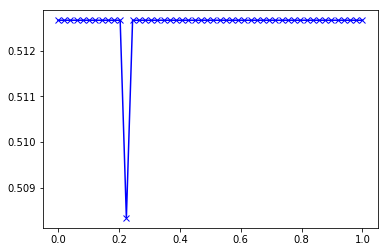

In [27]:
plt.plot(thresholds,ious,'-xb')

In [28]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('Best IOU score: {0}, threshold used: {1}'.format(iou_best,threshold_best))

Best IOU score: 0.5126666666666667, threshold used: 0.18367346938775508


In [29]:

a=pred.squeeze(axis = 3)
print(y_valid.shape)


(600, 128, 128, 1)


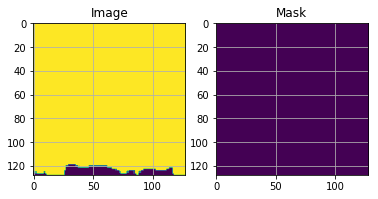

In [36]:
i=np.random.randint(0, y_valid.shape[0])

a= y_valid[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
b= pred[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
c = 255*X_valid[i,:,:,1].reshape((X_valid.shape[1],X_valid.shape[2]))

b[b>=threshold_best] = 1
b[b<threshold_best] = 0

plot2x2Array(a, np.round(b))

C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


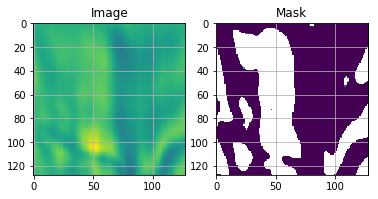

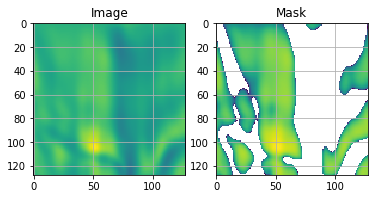

In [31]:
i=np.random.randint(0, y_valid.shape[0])

a= y_valid[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
b= pred[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
c = 255*X_valid[i,:,:,1].reshape((X_valid.shape[1],X_valid.shape[2]))
d = np.exp(c)
e = np.log(c+1)
e[e<0]=0

c.shape
d.shape
e.shape

plot2x2Array(c, d)
plot2x2Array(c, e)

In [32]:
a=np.array([1,-2,5,6])
a[a<0] = 0


In [33]:
print(a)


[1 0 5 6]
